In [2]:
import copy
import random
import shutil
from collections import Counter
from pathlib import Path

import clip
import cv2
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sparse
import torch
from medclip import MedCLIPProcessor, MedCLIPVisionModel
from PIL import Image, ImageOps
from pydicom import dcmread
from rich import print
from sklearn.manifold import TSNE
from torchvision.ops import roi_align
from tqdm.auto import tqdm

c:\Users\DryLab\anaconda3\envs\ViLLA\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Visualize Sample Data


In [146]:
DATA_DIR = "C:/Users/DryLab/Desktop/villa/data/docmnist_300000_29.5"
IMAGE_ID = 0

(3, 84, 84)

IMAGE:

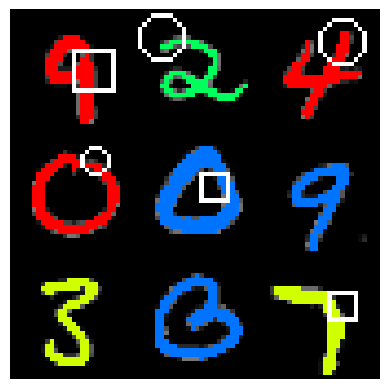

TEXT: the shape size is large . the shape is large . the shape appears to be a circle . the number is a three . 
there is a red image . the size of the shape is large . there is a rectangle . there is an image showing a seven . 
the shape size is medium . the digit appears to be blue . there is an image showing a nine . the number is a zero .
there is an image showing a three . the image has a rectangle . the image shows a zero . the image is red . the 
shape appears to be a rectangle . the digit appears to be green . the digit appears to be red . the number is a two
. the image has a circle . the image shows a four . the image is yellow . there is a circle . the image shows a 
nine . the shape is medium

REGION-ATTRIBUTE PAIRS:

REGION 1: ['nine' 'red' 'rectangle' 'large']

REGION 2: ['two' 'green' 'circle' 'large']

REGION 3: ['four' 'red' 'circle' 'large']

REGION 4: ['zero' 'red' 'circle' 'medium']

REGION 5: ['zero' 'blue' 'rectangle' 'medium']

REGION 6: ['nine' 'blue']

REGION 7: ['three' 'yellow']

REGION 8: ['three' 'blue']

REGION 9: ['seven' 'yellow' 'rectangle' 'medium']

In [147]:
# Load image and annotations
img = sparse.load_npz(f"{DATA_DIR}/images/{IMAGE_ID}.npz").todense() / 255
print(img.shape)
df = pd.read_feather(f"{DATA_DIR}/annotations.feather")
row = df[df["image_id"] == IMAGE_ID]

# Print image
print("IMAGE:")
plt.imshow(np.transpose(img, (1, 2, 0)))
plt.axis(False)
plt.show()

# Print text
caption = row["text"].values[0]
print("TEXT:", caption)

# Print region-attribute pairs
print("REGION-ATTRIBUTE PAIRS:")
mappings = row["reg_to_attr"].values[0]
for i in range(len(mappings)):
    print(f"\tREGION {i+1}:", mappings[i])

In [148]:
DATA_DIR = "C:/Users/DryLab/Desktop/villa/data/docmnist_300000_29.5"
df = pd.read_feather(f"{DATA_DIR}/annotations.feather")

In [149]:
df

,image_id,image_size,image_filepath,region_coord,num_regions,split,text,digit_label,color_label,shape_label,size_label,reg_to_attr,attributes
0,0,"[84, 84]",C:\Users\DryLab\Desktop\ViLLA\data\docmnist_30...,"[[0, 0, 28, 28], [28, 0, 56, 28], [56, 0, 84, ...",9,train,the shape size is large . the shape is large ....,"[nine, two, four, zero, zero, nine, three, thr...","[red, green, red, red, blue, blue, yellow, blu...","[rectangle, circle, circle, circle, rectangle,...","[large, large, large, medium, medium, None, No...","[[nine, red, rectangle, large], [two, green, c...","[red, seven, yellow, circle, green, blue, larg..."
1,1,"[84, 84]",C:\Users\DryLab\Desktop\ViLLA\data\docmnist_30...,"[[0, 0, 28, 28], [28, 0, 56, 28], [56, 0, 84, ...",9,train,there is an image showing a four . there is a ...,"[six, zero, four, zero, one, eight, four, nine...","[purple, green, purple, yellow, green, blue, p...","[None, circle, circle, rectangle, None, circle...","[None, small, medium, large, None, medium, Non...","[[six, purple], [zero, green, circle, small], ...","[six, yellow, circle, small, one, green, blue,..."
2,2,"[84, 84]",C:\Users\DryLab\Desktop\ViLLA\data\docmnist_30...,"[[0, 0, 28, 28], [28, 0, 56, 28], [56, 0, 84, ...",8,train,the digit appears to be one . there is an imag...,"[zero, seven, five, nine, one, seven, one, six]","[green, yellow, yellow, green, red, red, yello...","[None, rectangle, rectangle, circle, circle, c...","[None, medium, large, small, medium, medium, m...","[[zero, green], [seven, yellow, rectangle, med...","[red, seven, yellow, six, circle, small, one, ..."
3,3,"[84, 84]",C:\Users\DryLab\Desktop\ViLLA\data\docmnist_30...,"[[0, 0, 28, 28], [28, 0, 56, 28], [56, 0, 84, ...",9,train,there is a red image . the number is a one . t...,"[six, zero, two, eight, five, two, one, eight,...","[purple, purple, yellow, red, purple, red, pur...","[rectangle, circle, None, rectangle, rectangle...","[small, large, None, large, small, None, None,...","[[six, purple, rectangle, small], [zero, purpl...","[red, six, yellow, small, circle, one, blue, g..."
4,4,"[84, 84]",C:\Users\DryLab\Desktop\ViLLA\data\docmnist_30...,"[[0, 0, 28, 28], [28, 0, 56, 28], [56, 0, 84, ...",9,train,the number is a zero . the image is yellow . t...,"[one, seven, three, six, five, seven, seven, n...","[yellow, yellow, blue, purple, red, yellow, gr...","[None, rectangle, circle, circle, None, rectan...","[None, large, small, large, None, small, large...","[[one, yellow], [seven, yellow, rectangle, lar...","[red, seven, yellow, six, circle, one, small, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10513,10513,"[84, 84]",C:\Users\DryLab\Desktop\ViLLA\data\docmnist_30...,"[[0, 0, 28, 28], [28, 0, 56, 28], [56, 0, 84, ...",8,val,there is a purple image . the size of the shap...,"[nine, eight, eight, four, nine, four, four, s...","[yellow, green, blue, yellow, blue, purple, bl...","[circle, circle, rectangle, None, circle, circ...","[large, large, medium, None, medium, large, me...","[[nine, yellow, circle, large], [eight, green,...","[purple, seven, yellow, circle, green, blue, l..."
10514,10514,"[84, 84]",C:\Users\DryLab\Desktop\ViLLA\data\docmnist_30...,"[[0, 0, 28, 28], [28, 0, 56, 28], [56, 0, 84, ...",8,val,the image has a circle . the image shows a fiv...,"[three, four, three, five, eight, two, six, one]","[purple, blue, green, red, yellow, green, purp...","[rectangle, rectangle, circle, circle, None, r...","[small, medium, medium, large, None, medium, s...","[[three, purple, rectangle, small], [four, blu...","[red, six, yellow, small, circle, one, blue, g..."
10515,10515,"[84, 84]",C:\Users\DryLab\Desktop\ViLLA\data\docmnist_30...,"[[0, 0, 28, 28], [28, 0, 56, 28], [56, 0, 84, ...",8,val,the size of the shape is medium . there is a c...,"[one, eight, zero, zero, four, five, two, one]","[yellow, green, purple, purple, purple, blue, ...","[rectangle, rectangle, rectangle, None, circle...","[medium, large, small, None, large, medium, la...

In [150]:
df["reg_to_attr"].iloc[0]

array([array(['nine', 'red', 'rectangle', 'large'], dtype=object),
       array(['two', 'green', 'circle', 'large'], dtype=object),
       array(['four', 'red', 'circle', 'large'], dtype=object),
       array(['zero', 'red', 'circle', 'medium'], dtype=object),
       array(['zero', 'blue', 'rectangle', 'medium'], dtype=object),
       array(['nine', 'blue'], dtype=object),
       array(['three', 'yellow'], dtype=object),
       array(['three', 'blue'], dtype=object),
       array(['seven', 'yellow', 'rectangle', 'medium'], dtype=object)],
      dtype=object)

In [7]:
df["num_regions"].mean()

8.853489256512646

In [8]:
df["num_regions"].value_counts()

num_regions
9    8977
8    1541
Name: count, dtype: int64

In [9]:
df.split.value_counts()

split
train    10179
val        339
Name: count, dtype: int64

In [10]:
df["region_coord"].iloc[0]

array([array([ 0,  0, 28, 28]), array([28,  0, 56, 28]),
       array([56,  0, 84, 28]), array([ 0, 28, 28, 56]),
       array([28, 28, 56, 56]), array([56, 28, 84, 56]),
       array([ 0, 56, 28, 84]), array([28, 56, 56, 84]),
       array([56, 56, 84, 84])], dtype=object)

### Generate Region Embeddings on Sample Data


In [11]:
def generate_region_embs(out_dir):
    """
    Generate embeddings for each region.

    Parameters:
        out_dir: Directory for storing region embeddings
    """
    ann = pd.read_feather(f"{out_dir}/annotations.feather")
    components = {}
    out_dir = Path(out_dir) / "region_embs"
    if out_dir.exists() and out_dir.is_dir():
        shutil.rmtree(out_dir)
    out_dir.mkdir()

    # Load CLIP vision encoder
    model, _ = clip.load("RN50", "cuda")
    model_backbone, _ = clip.load("RN50", "cuda")
    components["model_backbone"] = model_backbone.to(torch.float32)
    for c in ["attnpool", "layer4"]:
        components[c] = copy.deepcopy(eval(f"model_backbone.visual.{c}"))
        setattr(model_backbone.visual, c, torch.nn.Identity())
    for c in ["transformer", "token_embedding", "ln_final"]:
        setattr(model_backbone, c, torch.nn.Identity())

    # Generate embeddings for each region
    reg_emb_map = {"image_id": [], "file": [], "file_id": []}
    all_reg_embs = []
    for idx, row in tqdm(ann.iterrows()):
        image_id, filepath = row["image_id"], row["image_filepath"]
        image = torch.tensor(
            (sparse.load_npz(filepath).todense() / 255).astype(np.float32)
        )
        image = torch.stack([image]).cuda()
        regions = np.stack(row["region_coord"].tolist())

        with torch.no_grad():
            features = components["model_backbone"].encode_image(image)
            rois = (
                torch.cat((torch.zeros((len(regions), 1)), torch.tensor(regions)), 1)
                .to(torch.float32)
                .cuda()
            )
            x = roi_align(
                features,
                rois.to(dtype=features.dtype),
                (14, 14),
                features.shape[-1] / image.shape[-1],
                0,
                True,
            )
            x = components["layer4"](x)
            x = components["attnpool"](x)
            # print(f"Shape of {idx} Embedding: {x.shape}")
            reg_embs = x

        if len(all_reg_embs) == 10000:
            all_reg_embs = np.array(all_reg_embs, dtype=object)
            print(f"Shape of all embeddings: {all_reg_embs.shape}")
            np.savez_compressed(out_dir / f"embs_{idx}", all_reg_embs)
            reg_emb_map["file"].extend([f"embs_{idx}"] * all_reg_embs.shape[0])
            reg_emb_map["file_id"].extend(np.arange(all_reg_embs.shape[0]))
            all_reg_embs = []
        reg_embs = reg_embs.cpu().numpy()
        all_reg_embs.append(
            reg_embs.reshape(
                -1,
            )
        )
        reg_emb_map["image_id"].append(image_id)

    all_reg_embs = np.array(all_reg_embs, dtype=object)
    np.savez_compressed(out_dir / f"embs_{idx}", all_reg_embs)
    reg_emb_map["file"].extend([f"embs_{idx}"] * all_reg_embs.shape[0])
    reg_emb_map["file_id"].extend(np.arange(all_reg_embs.shape[0]))

    pd.DataFrame(reg_emb_map).to_feather(out_dir / "region_emb_mapping.feather")
    print(f"Saved region embeddings to {out_dir}")

In [12]:
generate_region_embs("C:/Users/DryLab/Desktop/villa/data/docmnist_300000_29.5")

0it [00:00, ?it/s]c:\Users\DryLab\anaconda3\envs\ViLLA\lib\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
9992it [01:52, 87.38it/s]

Shape of all embeddings: (10000,)

10518it [02:08, 81.55it/s]


Saved region embeddings to C:\Users\DryLab\Desktop\villa\data\docmnist_300000_29.5\region_embs

### Check shape of data and visualize the layer on one sample


In [99]:
def generate_region_embs(image_id, out_dir):
    """
    Generate embeddings for a single region using CLIP and print the shapes of the outputs.

    Parameters:
        image_id: ID of the image to process
        out_dir: Directory containing annotation file and image data
    """
    ann = pd.read_feather(f"{out_dir}/annotations.feather")
    components = {}

    # Load CLIP vision encoder
    model, _ = clip.load("RN50", "cuda")
    model_backbone, _ = clip.load("RN50", "cuda")
    components["model_backbone"] = model_backbone.to(torch.float32)

    # Set a couple of components to identity, torch.nn.identity() is used to get the same results as the previous layer
    # which means we want to get the features before the attention pooling and layer 4

    # Copy attention pool and layer 4 components
    for c in ["attnpool", "layer4"]:
        components[c] = copy.deepcopy(eval(f"model_backbone.visual.{c}"))
        setattr(model_backbone.visual, c, torch.nn.Identity())

    # Set transformer-related components to identity
    for c in ["transformer", "token_embedding", "ln_final"]:
        setattr(model_backbone, c, torch.nn.Identity())

    # Find the row with the corresponding image_id
    row = ann[ann["image_id"] == image_id].iloc[0]
    filepath = row["image_filepath"]
    image = torch.tensor((sparse.load_npz(filepath).todense() / 255).astype(np.float32))
    print(image.shape)
    image = torch.stack([image]).cuda()
    print(image.shape)
    regions = np.stack(row["region_coord"].tolist())

    with torch.no_grad():
        # Generate image features
        print(f"Image shape: {image.shape}")
        features = components["model_backbone"].encode_image(image)
        print(f"Features shape: {features.shape}")

        # Process regions with ROI alignment
        rois = (
            torch.cat((torch.zeros((len(regions), 1)), torch.tensor(regions)), 1)
            .to(torch.float32)
            .cuda()
        )
        x = roi_align(
            features, rois, (14, 14), features.shape[-1] / image.shape[-1], 0, True
        )
        print(f"ROI-Aligned shape: {x.shape}")

        # Pass through layer4 and attention pooling
        x = components["layer4"](x)
        print(f"Layer4 shape: {x.shape}")
        x = components["attnpool"](x)
        print(f"Region embeddings shape: {x.shape}")

        return x

In [100]:
x = generate_region_embs(1, "C:/Users/DryLab/Desktop/ViLLA/data/docmnist_300000_29.5/")

torch.Size([3, 84, 84])

torch.Size([1, 3, 84, 84])

Image shape: torch.Size([1, 3, 84, 84])

Features shape: torch.Size([1, 1024, 5, 5])

ROI-Aligned shape: torch.Size([9, 1024, 14, 14])

Layer4 shape: torch.Size([9, 2048, 7, 7])

Region embeddings shape: torch.Size([9, 1024])

# EXPERIMENT USING MEDCLIP


### Create Preprocessing Steps for X-Ray Images


In [2]:
def process_image_dicom(filepath):
    dicom = dcmread(filepath)
    image = dicom.pixel_array

    # Convert 16-bit image to 8-bit image
    image = cv2.normalize(
        image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U
    )

    # Invert the image if the background is white
    if dicom.PhotometricInterpretation == "MONOCHROME1":
        image = Image.fromarray((image).astype(np.uint8)).convert("L")
        image = ImageOps.invert(image)
    else:
        image = Image.fromarray((image).astype(np.uint8)).convert("L")

    # Resize image
    image = image.resize((224, 224))

    # Convert Image object to numpy array and normalize
    image = np.array(image).astype(np.float32) / 255.0

    # Convert to tensor and add batch dimension
    image_tensor = torch.from_numpy(image).unsqueeze(0).unsqueeze(0).to(torch.float32)

    return image_tensor

In [31]:
def process_image(filepath):
    image = Image.open(filepath).convert("L")

    # Convert Image object to numpy array
    image = np.array(image)

    # Normalize image
    image = image.astype(np.float32) / 255.0

    # Apply histogram equalization
    image = cv2.equalizeHist((image * 255).astype(np.uint8)) / 255.0

    # Resize image
    image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_LINEAR)

    # Convert to tensor and add batch dimension
    image_tensor = torch.from_numpy(image).unsqueeze(0).to(torch.float32)

    return image_tensor

In [156]:
def pad_to_square(img):
    h, w = img.shape[:2]
    padh, padw, auxh, auxw = 0, 0, 0, 0  # Initialize padding variables
    if h > w:
        padw = h - w
        auxw = padw % 2
        img = np.pad(img, ((0, 0), (padw // 2, padw // 2 + auxw)), "constant")
    else:
        padh = w - h
        auxh = padh % 2
        img = np.pad(img, ((padh // 2, padh // 2 + auxh), (0, 0)), "constant")
    return img, (padh, padw, auxh, auxw)


def preprocess(input_img):
    img, padding = pad_to_square(input_img)
    h, w = img.shape[:2]
    if h != 224 or w != 224:
        img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC)
    return img, (h, w, padding)


def process_image_hybrid(filepath):
    image = cv2.imread(filepath, 0) / 255.0

    # Convert image to float32
    image = image.astype(np.float32)

    image, (h, w, padding) = preprocess(image)

    image = torch.from_numpy(image).unsqueeze(0).to(torch.float32)

    return image

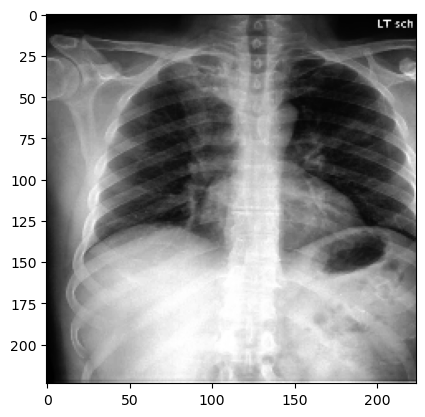

In [152]:
plt.imshow(process_image(df["image_filepath"].iloc[0]).squeeze(), cmap="gray")

torch.Size([1, 224, 224])

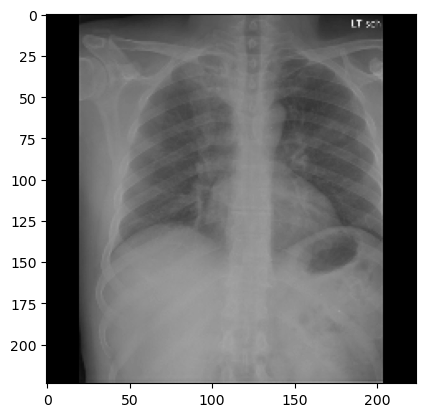

In [157]:
plt.imshow(process_image_hybrid(df["image_filepath"].iloc[0]).squeeze(), cmap="gray")
process_image_hybrid(df["image_filepath"].iloc[0]).shape

In [47]:
df = pd.read_feather(
    "C:/Users/DryLab/Desktop/ViLLA/data/open-i/annotations_region_final.feather"
)

In [48]:
df

,image_id,image_size,image_filepath,region_coord,region_bbox,region_labels,num_regions,text_filepath
0,0,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[22.0, 19.0, 119.0, 145.0], [136.0, 19.0, 223...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...
1,1,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 16.0, 99.0, 161.0], [117.0, 17.0, 219.0...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...
2,2,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[45.0, 43.0, 109.0, 175.0], [122.0, 42.0, 200...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...
3,3,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[35.0, 13.0, 109.0, 192.0], [115.0, 12.0, 194...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...
4,4,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[5.0, 34.0, 96.0, 177.0], [108.0, 32.0, 200.0...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...
...,...,...,...,...,...,...,...,...
3790,3790,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[33.0, 11.0, 121.0, 174.0], [128.0, 14.0, 204...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...
3791,3791,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[22.0, 8.0, 111.0, 210.0], [119.0, 7.0, 200.0...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...
3792,3792,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[22.0, 0.0, 107.0, 156.0], [116.0, 0.0, 196.0...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...
3793,3793,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[37.0, 14.0, 116.0, 160.0], [122.0, 15.0, 197...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...


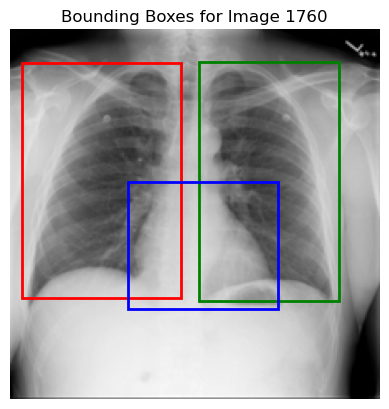

In [51]:
index = random.randint(0, len(df))


def resize_bounding_box(bbox, orig_width, orig_height, target_size=224):
    """
    Resizes bounding box coordinates to fit a target image size.

    Parameters:
    bbox (tuple): Original bounding box coordinates as (x_min, y_min, x_max, y_max).
    orig_width (int): Width of the original image.
    orig_height (int): Height of the original image.
    target_size (int): Target dimension (width and height) for the resized image.

    Returns:
    tuple: Resized bounding box coordinates (x_min_resized, y_min_resized, x_max_resized, y_max_resized).
    """
    x_min, y_min, x_max, y_max = bbox

    # Calculate scaling factors
    scale_x = target_size / orig_width
    scale_y = target_size / orig_height

    # Scale coordinates
    x_min_resized = int(x_min * scale_x)
    y_min_resized = int(y_min * scale_y)
    x_max_resized = int(x_max * scale_x)
    y_max_resized = int(y_max * scale_y)

    return (x_min_resized, y_min_resized, x_max_resized, y_max_resized)


def plot_bounding_boxes_for_index(
    df, index, image_column="image_filepath", bbox_column="region_bbox"
):
    # Load the image using the index
    image_path = df[image_column].iloc[index]
    image = Image.open(image_path).convert("L")
    # original_width, original_height = image.size
    processor = MedCLIPProcessor()
    image = processor(images=image)["pixel_values"][0]

    # Extract the bounding boxes
    bounding_boxes = df[bbox_column].iloc[index]

    # Plot the image with bounding boxes
    fig, ax = plt.subplots(1)
    ax.imshow(image.squeeze(), cmap="gray")

    # Unpack the bounding boxes
    left_lung_bbox = bounding_boxes[0]
    right_lung_bbox = bounding_boxes[1]
    heart_bbox = bounding_boxes[2]

    # # Resize bounding boxes to fit the image
    # left_lung_bbox = resize_bounding_box(
    #     left_lung_bbox, original_width, original_height
    # )
    # right_lung_bbox = resize_bounding_box(
    #     right_lung_bbox, original_width, original_height
    # )
    # heart_bbox = resize_bounding_box(heart_bbox, original_width, original_height)

    # Define bounding boxes' colors
    colors = ["r", "g", "b"]  # Red for right lung, Green for left lung, Blue for heart

    # Create rectangles for each bounding box and add them to the plot
    for bbox, color in zip([left_lung_bbox, right_lung_bbox, heart_bbox], colors):
        if not np.array_equal(
            bbox, [0, 0, 0, 0]
        ):  # Skip if the bbox is just a placeholder
            rect = patches.Rectangle(
                (bbox[0], bbox[1]),
                bbox[2] - bbox[0],
                bbox[3] - bbox[1],
                linewidth=2,
                edgecolor=color,
                facecolor="none",
            )
            ax.add_patch(rect)

    # Hide axis and show the plot
    plt.title(f"Bounding Boxes for Image {index}")
    plt.axis(False)
    plt.show()


# Example usage
plot_bounding_boxes_for_index(df, index)

In [160]:
image = df["image_filepath"].iloc[0]
image = Image.open(image).convert("L")

In [161]:
processor = MedCLIPProcessor()
image = processor(images=image)

In [162]:
image["pixel_values"][0].shape

(1, 224, 224)

Text(0.5, 1.0, 'Manual Preprocess')

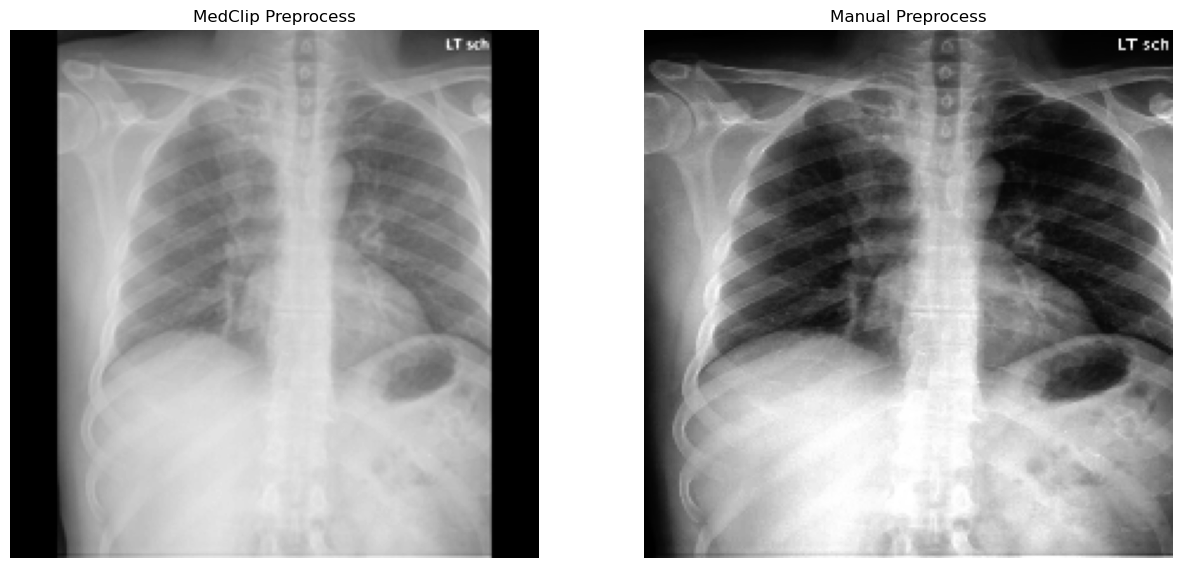

In [165]:
plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
plt.imshow(image["pixel_values"][0][0], cmap="gray")
plt.axis(False)
plt.title("MedClip Preprocess")

plt.subplot(1, 2, 2)
plt.imshow(process_image(df["image_filepath"].iloc[0]).squeeze(), cmap="gray")
plt.axis(False)
plt.title("Manual Preprocess")

## Use MedCLIP to generate embeddings for one image and check the layer shape


In [9]:
def generate_region_embs(image_id, out_dir):
    """
    Generate embeddings for a single region using CLIP and print the shapes of the outputs.

    Parameters:
        image_id: ID of the image to process
        out_dir: Directory containing annotation file and image data
    """
    ann = pd.read_feather(f"{out_dir}/annotations_region_final.feather")
    components = {}

    # Load MedCLIP vision encoder
    processor = MedCLIPProcessor()
    model = MedCLIPVisionModel()
    model.load_from_medclip("pretrained/medclip-resnet")
    image_encoder = model
    image_encoder = image_encoder.to("cuda")

    for layer in ["layer4", "avgpool", "fc"]:
        components[layer] = copy.deepcopy(eval(f"image_encoder.model.{layer}"))
        setattr(image_encoder.model, layer, torch.nn.Identity())
    # for layer in ["layer4"]:
    # setattr(image_encoder.model, layer, torch.nn.Identity())

    # Find the row with the corresponding image_id
    row = ann[ann["image_id"] == image_id].iloc[0]
    filepath = row["image_filepath"]
    image = Image.open(filepath).convert("L")
    image = processor(images=image, return_tensors="pt")
    image = image["pixel_values"][0]
    print(f"Original image input: {image.shape}")
    image = torch.stack([image]).cuda()
    print(f"Image stacked: {image.shape}")
    regions = np.stack(row["region_bbox"].tolist())

    with torch.no_grad():
        # Generate image features
        print(f"Image input shape: {image.shape}")
        features = image_encoder.forward(image)
        features = features.reshape(1, 1024, 14, 14)
        print(f"Features shape: {features.shape}")

        # Process regions with ROI alignment
        rois = (
            torch.cat((torch.zeros((len(regions), 1)), torch.tensor(regions)), 1)
            .to(torch.float32)
            .cuda()
        )
        x = roi_align(
            features, rois, (14, 14), features.shape[-1] / image.shape[-1], 0, True
        )
        print(f"ROI-Aligned shape: {x.shape}")

        # Pass through layer4 and attention pooling
        # x = components["layer3"](x)
        # print(f"Layer3 shape: {x.shape}")
        x = components["layer4"](x)
        print(f"Layer4 shape: {x.shape}")
        x = components["avgpool"](x)
        x = x.flatten(1)
        x = components["fc"](x)
        print(f"Region embeddings shape: {x.shape}")

        return x

In [10]:
x = generate_region_embs(1, "C:/Users/DryLab/Desktop/ViLLA/data/open-i/")

c:\Users\DryLab\anaconda3\envs\ViLLA\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\DryLab\anaconda3\envs\ViLLA\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\DryLab\anaconda3\envs\ViLLA\lib\site-packages\medclip\modeling_medclip.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https:/

missing keys: []
unexpected keys: []
load model weight from: pretrained/medclip-resnet


Original image input: torch.Size([1, 224, 224])

Image stacked: torch.Size([1, 1, 224, 224])

Image input shape: torch.Size([1, 1, 224, 224])

Features shape: torch.Size([1, 1024, 14, 14])

ROI-Aligned shape: torch.Size([3, 1024, 14, 14])

Layer4 shape: torch.Size([3, 2048, 7, 7])

Region embeddings shape: torch.Size([3, 512])

### Use Mask directly to generate region embeddings


In [977]:
# def generate_region_embs(out_dir):
#     """
#     Generate embeddings for each region using MedCLIP.

#     Parameters:
#         out_dir: Directory for storing region embeddings
#     """
#     ann = pd.read_feather(f"{out_dir}/annotations_test.feather")
#     components = {}
#     out_dir = Path(out_dir) / "region_embs"
#     if out_dir.exists() and out_dir.is_dir():
#         shutil.rmtree(out_dir)
#     out_dir.mkdir()

#     # Load MedCLIP vision encoder
#     model = MedCLIPVisionModel()
#     model.load_from_medclip("C:/Users/DryLab/Desktop/ViLLA/pretrained/medclip-resnet")
#     image_encoder = model
#     image_encoder = image_encoder.to("cuda")

#     for layer in ["layer3", "avgpool"]:
#         components[layer] = copy.deepcopy(getattr(image_encoder.model, layer))
#         setattr(image_encoder.model, layer, torch.nn.Identity())
#     for layer in ["layer4", "fc"]:
#         setattr(image_encoder.model, layer, torch.nn.Identity())

#     # Prepare to store the embeddings
#     reg_emb_map = {"image_id": [], "file": [], "file_id": []}
#     all_reg_embs = []

#     # Generate embeddings for each region
#     for idx, row in tqdm(ann.iterrows(), total=len(ann)):
#         image_id, filepath = row["image_id"], row["image_filepath"]
#         # Load and resize the image
#         image = process_image(filepath).cuda()
#         image = torch.stack([image])
#         regions = row["region_coord"]  # These are the multiclass masks

#         with torch.no_grad():
#             # Generate image features
#             features = image_encoder(image)

#             # Initialize a list to store region embeddings for each class
#             all_class_embs = []

#             for mask in regions:
#                 # Convert mask to a tensor
#                 mask_tensor = torch.tensor(
#                     mask.reshape(224, 224), dtype=torch.float32
#                 ).cuda()

#                 # print(f"Mask tensor shape: {mask_tensor.shape}")

#                 # Resize the mask to match the feature map size
#                 mask_tensor = F.interpolate(
#                     mask_tensor.unsqueeze(0).unsqueeze(0),
#                     size=features.shape[-2:],
#                     mode="nearest",
#                 )

#                 # print(f"Mask tensor after reshape: {mask_tensor.shape}")

#                 # Apply the mask to the feature map
#                 masked_features = features * mask_tensor
#                 # print(f"Masked features shape: {masked_features.shape}")
#                 # Perform global average pooling on the masked features
#                 masked_features = components["layer3"](masked_features)
#                 pooled_features = (
#                     components["avgpool"](masked_features).squeeze(-1).squeeze(-1)
#                 )
#                 # print(f"Pooled features shape: {pooled_features.shape}")
#                 all_class_embs.append(pooled_features)

#             # Concatenate embeddings for all classes
#             reg_embs = torch.cat(all_class_embs, dim=0).cpu().numpy()
#             # print(f"Final region embeddings shape: {reg_embs.shape}")
#             all_reg_embs.append(reg_embs.reshape(-1))

#             if len(all_reg_embs) >= 2000:
#                 all_reg_embs = np.array(all_reg_embs, dtype=object)
#                 print(f"Shape of all embeddings: {all_reg_embs.shape}")
#                 np.savez_compressed(
#                     out_dir / f"embs_{idx}", all_reg_embs, allow_pickle=True
#                 )
#                 reg_emb_map["file"].extend([f"embs_{idx}"] * all_reg_embs.shape[0])
#                 reg_emb_map["file_id"].extend(np.arange(all_reg_embs.shape[0]))
#                 all_reg_embs = []

#             reg_emb_map["image_id"].append(image_id)

#     # Save any remaining embeddings
#     if all_reg_embs:
#         all_reg_embs = np.array(all_reg_embs, dtype=object)
#         np.savez_compressed(out_dir / f"embs_{idx}", all_reg_embs, allow_pickle=True)
#         reg_emb_map["file"].extend([f"embs_{idx}"] * all_reg_embs.shape[0])
#         reg_emb_map["file_id"].extend(np.arange(all_reg_embs.shape[0]))

#     # Save the mapping of region embeddings
#     pd.DataFrame(reg_emb_map).to_feather(out_dir / "region_emb_mapping.feather")
#     print(f"Saved region embeddings to {out_dir}")


In [3]:
# generate_region_embs("C:/Users/DryLab/Desktop/ViLLA/data/open-i")

### Generate Region Embeddings for X-Ray Images using MedCLIP


In [4]:
def generate_region_embs(out_dir):
    """
    Generate embeddings for each region.

    Parameters:
        out_dir: Directory for storing region embeddings
    """
    ann = pd.read_feather(f"{out_dir}/annotations.feather")
    components = {}
    out_dir = Path(out_dir) / "region_embs"
    if out_dir.exists() and out_dir.is_dir():
        shutil.rmtree(out_dir)
    out_dir.mkdir()

    # Load MedCLIP vision encoder
    # processor = MedCLIPProcessor()
    model = MedCLIPVisionModel()
    model.load_from_medclip("C:/Users/DryLab/Desktop/ViLLA/pretrained/medclip-resnet")
    image_encoder = model
    image_encoder = image_encoder.to("cuda")

    for layer in ["layer3", "layer4", "avgpool", "fc"]:
        components[layer] = copy.deepcopy(eval(f"image_encoder.model.{layer}"))
        setattr(image_encoder.model, layer, torch.nn.Identity())
    # for layer in ["layer4", "fc"]:
    #     setattr(image_encoder.model, layer, torch.nn.Identity())

    # Generate embeddings for each region
    reg_emb_map = {"image_id": [], "file": [], "file_id": []}
    all_reg_embs = []
    for idx, row in tqdm(ann.iterrows()):
        image_id, filepath = row["image_id"], row["image_filepath"]
        image = process_image(filepath).cuda()
        # image = Image.open(filepath).convert("L")
        # original_width, original_height = image.size
        # image = processor(images=image, return_tensors="pt")["pixel_values"][0].cuda()
        image = torch.stack([image])
        # regions = [
        #     resize_bounding_box(bbox, original_width, original_height)
        #     for bbox in row["region_bbox"]
        # ]
        regions = np.stack(row["region_bbox"].tolist())

        with torch.no_grad():
            features = image_encoder(image).reshape(1, 512, 28, 28)
            rois = (
                torch.cat((torch.zeros((len(regions), 1)), torch.tensor(regions)), 1)
                .to(torch.float32)
                .cuda()
            )
            x = roi_align(
                features,
                rois.to(dtype=features.dtype),
                (14, 14),
                features.shape[-1] / image.shape[-1],
                0,
                True,
            )

            x = components["layer3"](x)
            # x = components["layer4"](x)
            x = components["avgpool"](x).flatten(1)
            # x = components["fc"](x)
            reg_embs = x

        if len(all_reg_embs) == 2000:
            all_reg_embs = np.array(all_reg_embs, dtype=object)
            print(f"Shape of all embeddings: {all_reg_embs.shape}")
            np.savez_compressed(out_dir / f"embs_{idx}", all_reg_embs)
            reg_emb_map["file"].extend([f"embs_{idx}"] * all_reg_embs.shape[0])
            reg_emb_map["file_id"].extend(np.arange(all_reg_embs.shape[0]))
            all_reg_embs = []
        reg_embs = reg_embs.cpu().numpy()
        all_reg_embs.append(
            reg_embs.reshape(
                -1,
            )
        )
        reg_emb_map["image_id"].append(image_id)

    all_reg_embs = np.array(all_reg_embs, dtype=object)
    np.savez_compressed(out_dir / f"embs_{idx}", all_reg_embs)
    reg_emb_map["file"].extend([f"embs_{idx}"] * all_reg_embs.shape[0])
    reg_emb_map["file_id"].extend(np.arange(all_reg_embs.shape[0]))

    pd.DataFrame(reg_emb_map).to_feather(out_dir / "region_emb_mapping.feather")
    print(f"Saved region embeddings to {out_dir}")

In [5]:
generate_region_embs("C:/Users/DryLab/Desktop/ViLLA/data/open-i")

c:\Users\DryLab\anaconda3\envs\ViLLA\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\DryLab\anaconda3\envs\ViLLA\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\DryLab\anaconda3\envs\ViLLA\lib\site-packages\medclip\modeling_medclip.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https:/

missing keys: []
unexpected keys: []
load model weight from: C:/Users/DryLab/Desktop/ViLLA/pretrained/medclip-resnet


2000it [00:35, 54.41it/s]

Shape of all embeddings: (2000, 3072)

2011it [00:39, 50.89it/s]


Saved region embeddings to C:\Users\DryLab\Desktop\ViLLA\data\open-i\region_embs

### Plot TSNE


In [888]:
df = pd.read_feather("C:/Users/DryLab/Desktop/ViLLA/data/open-i/annotations.feather")

In [889]:
def load_region_embs(out_dir):
    out_dir = Path(out_dir)
    emb_files = list(out_dir.glob("region_embs/embs_*.npz"))
    all_embs = []
    for emb_file in emb_files:
        data = np.load(emb_file, allow_pickle=True)
        all_embs.extend(data["arr_0"])
    emb_map = pd.read_feather(out_dir / "region_embs/region_emb_mapping.feather")
    return all_embs, emb_map

In [891]:
embeddings, emb_map = load_region_embs("C:/Users/DryLab/Desktop/ViLLA/data/open-i/")

In [892]:
reshaped_embeddings = np.array(embeddings).reshape(len(embeddings), -1, 1024)

In [893]:
reshaped_embeddings.shape

(1962, 3, 1024)

In [894]:
flattened_embeddings = reshaped_embeddings.reshape(-1, 1024)
flattened_embeddings.shape

(5886, 1024)

In [895]:
emb_map

,image_id,file,file_id
0,0,embs_1961,0
1,1,embs_1961,1
2,2,embs_1961,2
3,3,embs_1961,3
4,4,embs_1961,4
...,...,...,...
1957,1957,embs_1961,1957
1958,1958,embs_1961,1958
1959,1959,embs_1961,1959
1960,1960,embs_1961,1960


In [896]:
def plot_tsne(embeddings, perplexity=30, n_iter=1000, random_state=42):
    # Flatten embeddings if necessary
    embeddings = np.array([emb.flatten() for emb in embeddings])

    # Perform t-SNE
    tsne = TSNE(
        n_components=2, perplexity=perplexity, n_iter=n_iter, random_state=random_state
    )
    tsne_result = tsne.fit_transform(embeddings)

    return tsne_result

In [897]:
tsne_results = plot_tsne(flattened_embeddings)

c:\Users\DryLab\anaconda3\envs\ViLLA\lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [898]:
tsne_results.shape

(5886, 2)

In [899]:
labels = np.array([label for sublist in df["region_labels"] for label in sublist])
labels = labels.reshape(-1, 3)
labels = labels.reshape(-1)
labels.shape

(5886,)

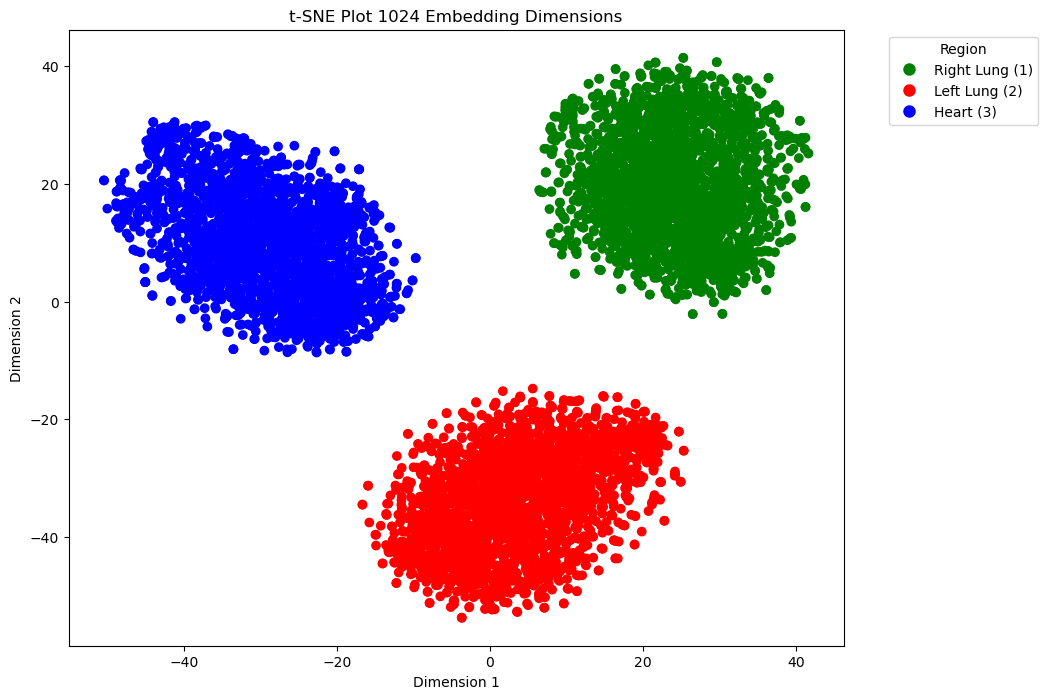

In [900]:
# Map the labels to colors
color_map = {1: "green", 2: "red", 3: "blue"}
colors = [color_map[label] for label in labels]

# Create the t-SNE plot
plt.figure(figsize=(10, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=colors)

# Add a custom legend
handles = [
    plt.Line2D(
        [0], [0], marker="o", color="w", markerfacecolor=color_map[lbl], markersize=10
    )
    for lbl in color_map
]
plt.legend(
    handles,
    ["Right Lung (1)", "Left Lung (2)", "Heart (3)"],
    title="Region",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
)

# Add titles and labels
plt.title("t-SNE Plot 1024 Embedding Dimensions")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

# Show the plot
plt.show()

In [15]:
# Step 1: Calculate centroids for each region
regions = np.unique(labels)
centroids = np.array(
    [np.mean(tsne_results[labels == region], axis=0) for region in regions]
)

In [16]:
centroids

array([[-29.594614, -41.944218],
       [-19.055202,  47.191883],
       [ 49.777912,  -4.448619]], dtype=float32)

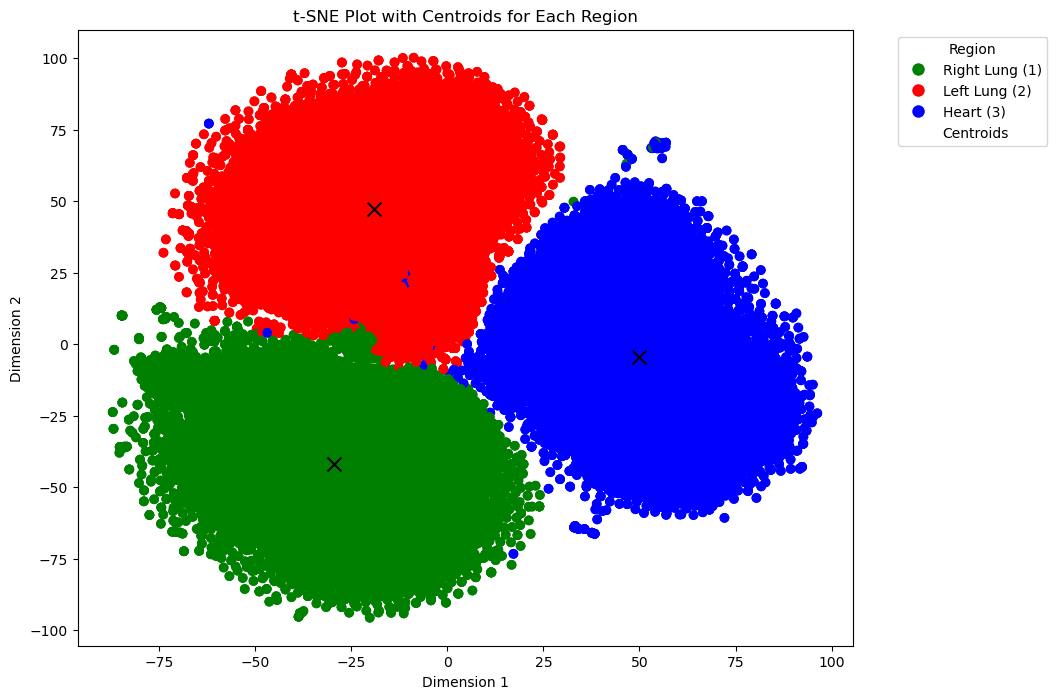

In [17]:
# Plot the t-SNE results with centroids
plt.figure(figsize=(10, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=colors)
plt.scatter(centroids[:, 0], centroids[:, 1], c="black", marker="x", s=100)

# Add a custom legend for the regions and centroids
handles = [
    plt.Line2D(
        [0], [0], marker="o", color="w", markerfacecolor=color_map[lbl], markersize=10
    )
    for lbl in color_map
]

handles.append(
    plt.Line2D([0], [0], marker="x", color="w", markerfacecolor="black", markersize=10)
)

plt.legend(
    handles,
    ["Right Lung (1)", "Left Lung (2)", "Heart (3)", "Centroids"],
    title="Region",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
)

# Add titles and labels
plt.title("t-SNE Plot with Centroids for Each Region")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

# Show the plot
plt.show()

In [19]:
# Step 2: Calculate distances to the correct centroid for each point
distances = np.array(
    [
        np.linalg.norm(
            point - centroids[int(region) - 1]
        )  # Subtract 1 because labels start from 1
        for point, region in zip(tsne_results, labels)
    ]
)

# Step 3: Set a distance threshold (you can adjust this threshold)
threshold = 100.0  # Tune this threshold as needed
outliers = np.where(distances > threshold)[0]
print(f"Total number of outliers: {len(outliers)} = {outliers}")

Total number of outliers: 28 = [ 1518  2439  4527  6432  9621 11574 11669 13686 16893 17436 18978 20097
 20517 21279 24909 25599 29670 29718 30204 31931 33096 33720 33900 35658
 43785 44591 44607 44739]

In [20]:
# Calculate the number of regions per image
num_regions_per_image = 3

# Create a set to store indices of images to remove
images_to_remove = set()

# Loop through each outlier index
for outlier_index in outliers:
    # Determine the corresponding image index
    image_index = outlier_index // num_regions_per_image

    # Add the image index to the set of images to remove
    images_to_remove.add(image_index)

In [21]:
# Copy the outliers to a new dataframe
outliers_df = df.iloc[list(images_to_remove)].copy()
outliers_df.sort_index(inplace=True)
outliers_df

,image_id,image_size,image_filepath,region_coord,region_bbox,region_labels,num_regions,text_filepath,text,sentences,attributes,split
506,506,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/MIMIC-CXR/phys...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[nan, nan, nan, nan], [11.0, 32.0, 107.0, 151...","[[1], [2], [3]]",3,s53546396.txt,wet read version # 1 ___ ___ ___ 6 : 56 pm a m...,"[wet read version # 1 ___ ___ ___ 6, : 56 pm a...",[opacity],train
813,813,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/MIMIC-CXR/phys...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[nan, nan, nan, nan], [57.0, 22.0, 123.0, 170...","[[1], [2], [3]]",3,s53408340.txt,"an indwelling catheter is present , with tip o...","[an indwelling catheter is present , with tip ...",[small effusion],train
1509,1509,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/MIMIC-CXR/phys...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[154.0, 43.0, 154.0, 50.0], [16.0, 34.0, 182....","[[1], [2], [3]]",3,s56206556.txt,again seen is bilateral pleural effusion and a...,[again seen is bilateral pleural effusion and ...,"[surgical clips, place, atelectasis, et tube, ...",train
2144,2144,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/MIMIC-CXR/phys...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[163.0, 37.0, 191.0, 153.0], [47.0, 29.0, 128...","[[1], [2], [3]]",3,s56189368.txt,"as compared to the previous radiograph , there...","[as compared to the previous radiograph , ther...",[line],train
3207,3207,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/MIMIC-CXR/phys...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[131.0, 76.0, 176.0, 162.0], [28.0, 38.0, 107...","[[1], [2], [3]]",3,s51386202.txt,minimal displacement of the mediastinum toward...,[minimal displacement of the mediastinum towar...,"[minimal atelectasis, effusion, atelectasis]",train
3858,3858,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/MIMIC-CXR/phys...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[154.0, 43.0, 154.0, 50.0], [16.0, 34.0, 182....","[[1], [2], [3]]",3,s56206556.txt,again seen is bilateral pleural effusion and a...,[again seen is bilateral pleural effusion and ...,"[surgical clips, place, atelectasis, et tube, ...",train
3889,3889,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/MIMIC-CXR/phys...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[126.0, 82.0, 218.0, 185.0], [32.0, 28.0, 178...","[[1], [2], [3]]",3,s54912279.txt,"moderate cardiomegaly is re - demonstrated , u...","[moderate cardiomegaly is re - demonstrated , ...","[moderate cardiomegaly, atelectasis, elevation]",train
4562,4562,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/MIMIC-CXR/phys...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[nan, nan, nan, nan], [11.0, 32.0, 107.0, 151...","[[1], [2], [3]]",3,s53546396.txt,wet read version # 1 ___ ___ ___ 6 : 56 pm a m...,"[wet read version # 1 ___ ___ ___ 6, : 56 pm a...",[opacity],train
5631,5631,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/MIMIC-CXR/phys...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[172.0, 77.0, 187.0, 99.0], [71.0, 31.0, 133....","[[1], [2], [3]]",3,s54698338.txt,very limited examination . moderate cardiomega...,"[very limited examination ., moderate cardiome...",[moderate cardiomegaly],train
5812,5812,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/MIMIC-CXR/phys...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[nan, nan, nan, nan], [25.0, 10.0, 138.0, 175...","[[1], [2], [3]]",3,s53935886.txt,portable supine radiograph of the chest demons...,[portable supine radiograph of the chest demon...,"[sternotomy wires, endotracheal tube, small ef...",train


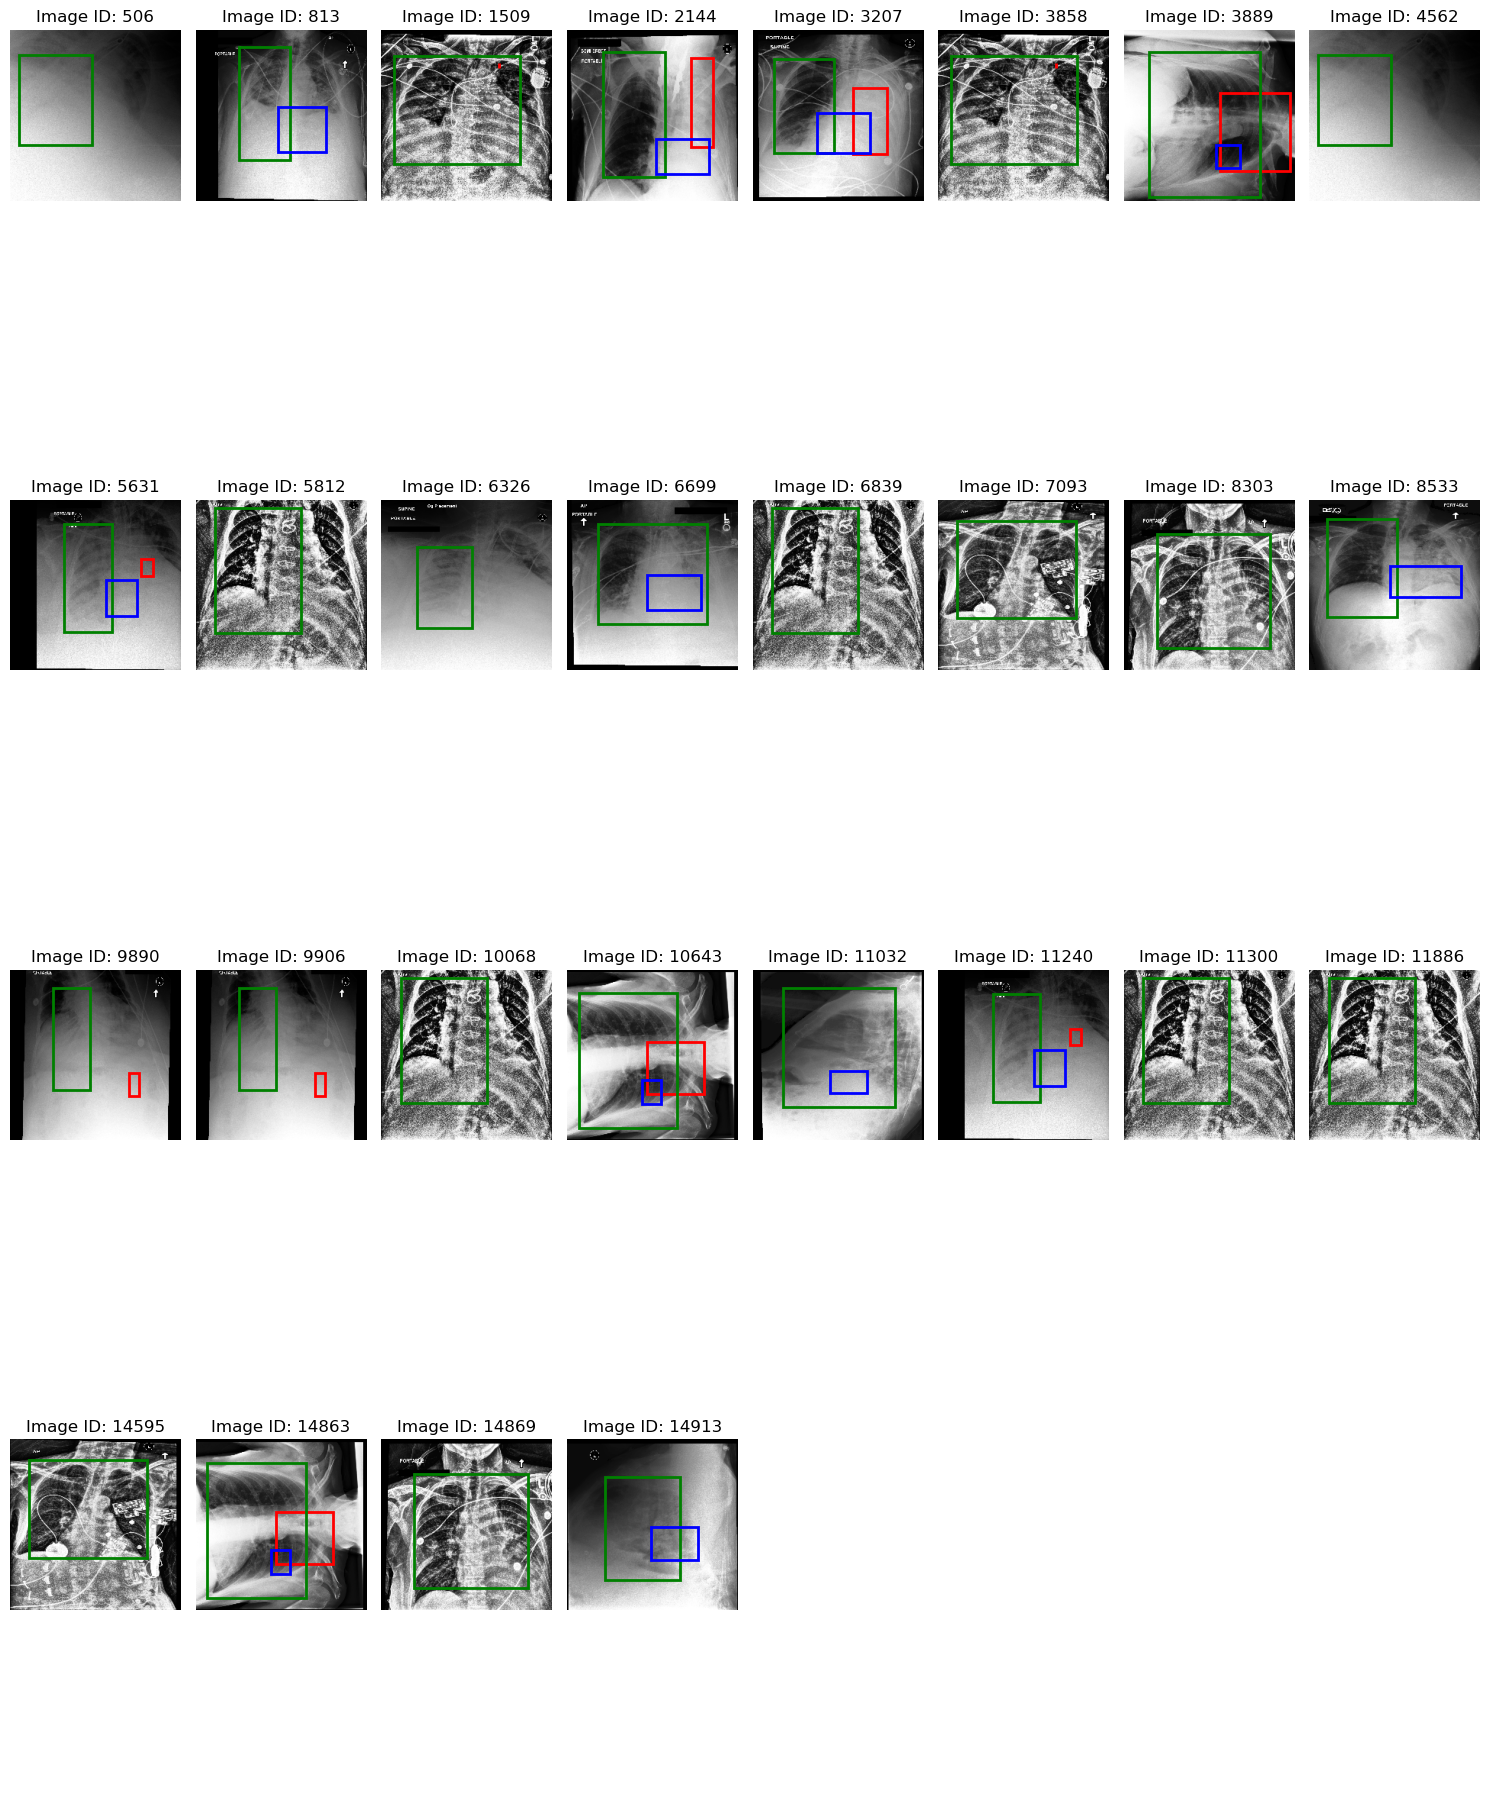

In [25]:
# Calculate the number of columns and rows
num_outliers = len(outliers_df)
n_cols = 8  # Number of columns in the plot
n_rows = (num_outliers + n_cols - 1) // n_cols  # Calculate the required number of rows

# Create figsize and subplot to plot the outliers
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten the axes for easy iteration if it's 2D
axs = axs.ravel()
# processor = MedCLIPProcessor()

# Loop through each outlier
for i, (_, row) in enumerate(outliers_df.iterrows()):
    # Load the image
    # image = Image.open(row["image_filepath"]).convert("L")
    # original_width, original_height = image.size
    # image = processor(images=image)
    # image = image["pixel_values"][0]
    image = process_image(row["image_filepath"]).squeeze()

    # Plot the image
    axs[i].imshow(image.squeeze(), cmap="gray")
    axs[i].axis("off")
    axs[i].set_title(f"Image ID: {row['image_id']}")

    # Get the bounding boxes for right lung, left lung, and heart
    bboxes = row[
        "region_bbox"
    ]  # This should be an array with 3 inner arrays [right lung, left lung, heart]

    # # Resize bounding boxes to fit the image
    # bboxes = [
    #     resize_bounding_box(bbox, original_width, original_height) for bbox in bboxes
    # ]

    # Define colors for each region
    colors = ["r", "g", "b"]  # Red for right lung, green for left lung, blue for heart

    # Iterate through each region (right lung, left lung, heart)
    for j, bbox in enumerate(bboxes):
        x_min, y_min, x_max, y_max = bbox
        # Create a rectangle patch for the bounding box
        rect = patches.Rectangle(
            (x_min, y_min),
            x_max - x_min,
            y_max - y_min,
            linewidth=2,
            edgecolor=colors[j],
            facecolor="none",
        )
        # Add the rectangle to the plot
        axs[i].add_patch(rect)

# Hide any unused subplots
for i in range(num_outliers, len(axs)):
    axs[i].axis("off")

plt.tight_layout()
plt.show()

In [79]:
# Remove the outliers
clean_tsne_results = np.delete(tsne_results, outliers, axis=0)
clean_embeddings = np.delete(flattened_embeddings, outliers, axis=0)
clean_labels = np.delete(labels, outliers, axis=0)
print(f"Removed {len(outliers)} outliers.")

Removed 0 outliers.

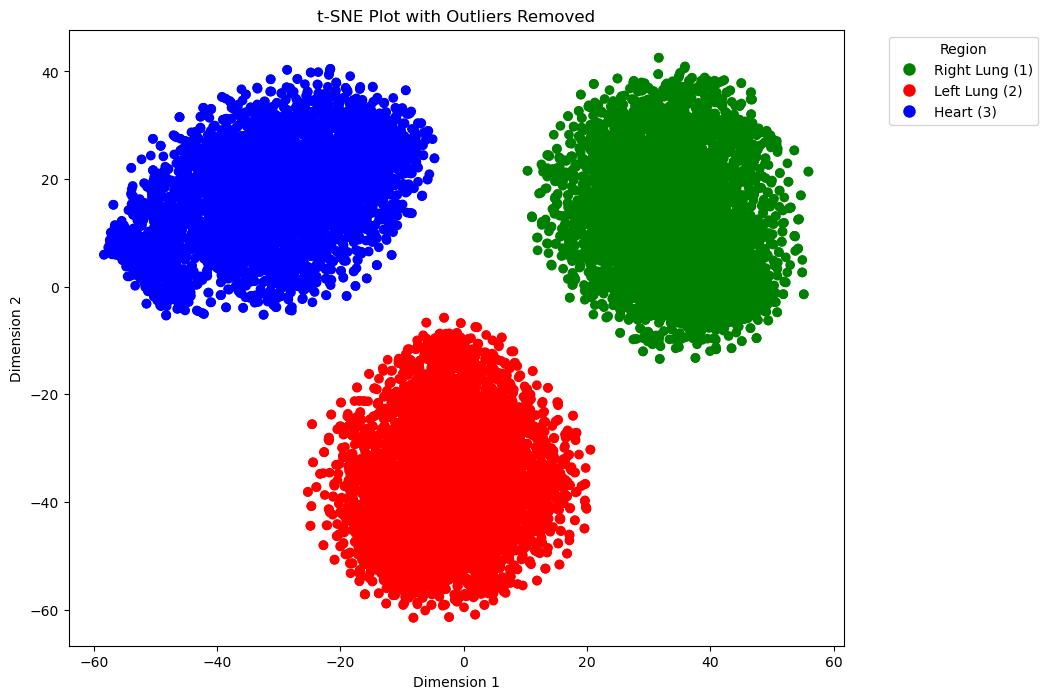

In [80]:
# Step 4: Replot the t-SNE results without the outliers
# Map the labels to colors
color_map = {1: "green", 2: "red", 3: "blue"}
colors = [color_map[label] for label in clean_labels]

plt.figure(figsize=(10, 8))
plt.scatter(clean_tsne_results[:, 0], clean_tsne_results[:, 1], c=colors)

# Add a custom legend
handles = [
    plt.Line2D(
        [0], [0], marker="o", color="w", markerfacecolor=color_map[lbl], markersize=10
    )
    for lbl in color_map
]
plt.legend(
    handles,
    ["Right Lung (1)", "Left Lung (2)", "Heart (3)"],
    title="Region",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
)

# Add titles and labels
plt.title("t-SNE Plot with Outliers Removed")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

# Show the plot
plt.show()

In [81]:
# Remove the identified images from the DataFrame
df_cleaned = df[~df.index.isin(images_to_remove)]
df_cleaned.reset_index(drop=True, inplace=True)
df_cleaned["image_id"] = range(len(df_cleaned))

# Display the cleaned DataFrame
df_cleaned

,image_id,image_size,image_filepath,region_coord,region_bbox,region_labels,num_regions,text_filepath,text,sentences,attributes,split
0,0,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[34.0, 12.0, 103.0, 139.0], [107.0, 16.0, 175...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,the heart is [MASK] within normal limits in si...,[the heart is [MASK] within normal limits in s...,[heart],train
1,1,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[7.0, 34.0, 94.0, 185.0], [103.0, 33.0, 192.0...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,lungs are overall hyperexpanded consistent wit...,[lungs are overall hyperexpanded consistent wi...,"[disease, limits, lungs]",train
2,2,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[29.0, 2.0, 112.0, 146.0], [121.0, 10.0, 196....","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,calcified granulomas are noted within the lung...,[calcified granulomas are noted within the lun...,[granulomas],train
3,3,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[18.0, 13.0, 98.0, 155.0], [108.0, 16.0, 177....","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,minimal cardiomegaly . prominent pulmonary [MA...,"[minimal cardiomegaly ., prominent pulmonary [...",[cardiomegaly],train
4,4,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[24.0, 16.0, 114.0, 148.0], [124.0, 16.0, 215...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,heart size and pulmonary vascularity are withi...,[heart size and pulmonary vascularity are with...,"[heart, size, vascularity]",train
...,...,...,...,...,...,...,...,...,...,...,...,...
3466,3466,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[42.0, 25.0, 122.0, 139.0], [129.0, 23.0, 196...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,heart size and mediastinal contour are normal ...,[heart size and mediastinal contour are normal...,"[atelectasis, density, effusion, heart, size]",val
3467,3467,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[26.0, 23.0, 106.0, 177.0], [116.0, 25.0, 197...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"the heart , pulmonary [MASK] and mediastinum a...","[the heart , pulmonary [MASK] and mediastinum ...","[degenerative changes, heart, mediastinum, nor...",val
3468,3468,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[22.0, 25.0, 120.0, 172.0], [131.0, 24.0, 217...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,heart size and pulmonary vascularity appear wi...,[heart size and pulmonary vascularity appear w...,"[degenerative changes, heart, size, vascularity]",val
3469,3469,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[30.0, 23.0, 105.0, 165.0], [111.0, 23.0, 182...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,the cardiomediastinal silhouette and pulmonary...,[the cardiomediastinal silhouette and pulmonar...,"[limits, silhouette, size, vasculature]",val


In [67]:
df_cleaned.to_feather(
    "C:/Users/DryLab/Desktop/ViLLA/data/open-i/annotations_region_final.feather"
)

## Attributes Embedding Check


In [298]:
ann = pd.read_feather("C:/Users/DryLab/Desktop/ViLLA/data/open-i/annotations.feather")
ann = ann[ann['split'] == 'train']

ATTRIBUTES = ['within normal limits',
 'atelectasis',
 'degenerative changes',
 'calcified granuloma',
 'opacities',
 'cardiomegaly',
 'disease',
 'calcifications',
 'emphysema',
 'midline',
 'opacity',
 'changes',
 'mild degenerative changes',
 'surgical clips',
 'mild cardiomegaly',
 'calcified lymph',
 'sternotomy',
 'calcification',
 'stable cardiomegaly',
 'mild degenerative',
 'effusion',
 'granulomatous disease',
 'tortuosity',
 'copd',
 'pneumonia',
 'osteophytes',
 'prominence',
 'normal appearance',
 'edema',
 'eventration',
 'effusions',
 'streaky opacities',
 'mild tortuosity',
 'minimal atelectasis',
 'minimal degenerative changes',
 'small effusions',
 'deformity',
 'hyperexpansion',
 'small effusion',
 'tip',
 'catheter tip',
 'elevation',
 'hyperinflation',
 'borderline',
 'emphysematous changes',
 'granuloma',
 'density',
 'congestion',
 'calcified granulomas',
 'hiatal hernia']

In [299]:
final_sentences = []
for attribute in ATTRIBUTES:
    # Identify sentences that contain the attribute from the "sentences" column
    sentences_with_attributes = []

    for i in range(len(ann["sentences"])):
        for j in range(len(ann["sentences"].iloc[i])):
            sentence = ann["sentences"].iloc[i][j]
            if attribute.lower() in sentence.lower():
                sentences_with_attributes.append(sentence)

    # Count the frequency of each sentence containing the attribute
    sentence_counter = Counter(sentences_with_attributes)

    # Get the 200 most frequent sentences
    most_common_sentences = [
        sentence for sentence, _ in sentence_counter.most_common(200)
    ]

    final_sentences.append(most_common_sentences)

    # print(final_sentences)


In [300]:
final_sentences = []
for attribute in ATTRIBUTES:
    # Split the attribute into individual words
    attribute_words = attribute.lower().split()

    # Identify sentences that contain any word from the attribute
    sentences_with_attributes = []

    for i in range(len(ann["sentences"])):
        for j in range(len(ann["sentences"].iloc[i])):
            sentence = ann["sentences"].iloc[i][j].lower()
            # Check if any word from attribute_words is in the sentence
            if any(word in sentence for word in attribute_words):
                sentences_with_attributes.append(ann["sentences"].iloc[i][j])

    # Count the frequency of each sentence containing the attribute
    sentence_counter = Counter(sentences_with_attributes)

    # Get the 200 most frequent sentences
    most_common_sentences = [
        sentence for sentence, _ in sentence_counter.most_common(200)
    ]

    # Append the result for each attribute
    final_sentences.append(most_common_sentences)

In [301]:
print(len(final_sentences))

50

In [302]:
for sentence in final_sentences:
    if len(sentence) != 200:
        print(
            f"Attributes {final_sentences.index(sentence) + 1} {ATTRIBUTES[final_sentences.index(sentence)]} with total sentences: {len(sentence)}"
        )


Attributes 5 opacities with total sentences: 196

Attributes 6 cardiomegaly with total sentences: 101

Attributes 7 disease with total sentences: 160

Attributes 8 calcifications with total sentences: 53

Attributes 9 emphysema with total sentences: 76

Attributes 10 midline with total sentences: 8

Attributes 11 opacity with total sentences: 137

Attributes 14 surgical clips with total sentences: 73

Attributes 16 calcified lymph with total sentences: 193

Attributes 17 sternotomy with total sentences: 51

Attributes 18 calcification with total sentences: 85

Attributes 21 effusion with total sentences: 131

Attributes 22 granulomatous disease with total sentences: 188

Attributes 23 tortuosity with total sentences: 42

Attributes 24 copd with total sentences: 22

Attributes 25 pneumonia with total sentences: 49

Attributes 26 osteophytes with total sentences: 15

Attributes 27 prominence with total sentences: 35

Attributes 29 edema with total sentences: 52

Attributes 30 eventration with total sentences: 14

Attributes 31 effusions with total sentences: 46

Attributes 36 small effusions with total sentences: 117

Attributes 37 deformity with total sentences: 39

Attributes 38 hyperexpansion with total sentences: 16

Attributes 39 small effusion with total sentences: 178

Attributes 40 tip with total sentences: 74

Attributes 41 catheter tip with total sentences: 84

Attributes 42 elevation with total sentences: 20

Attributes 43 hyperinflation with total sentences: 16

Attributes 44 borderline with total sentences: 15

Attributes 46 granuloma with total sentences: 192

Attributes 47 density with total sentences: 54

Attributes 48 congestion with total sentences: 22

Attributes 49 calcified granulomas with total sentences: 187

Attributes 50 hiatal hernia with total sentences: 29

In [216]:
from transformers import AutoModel, AutoTokenizer

# tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-mpnet-base-v2")

# model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

model = AutoModel.from_pretrained("sentence-transformers/all-mpnet-base-v2")


In [217]:
sentence = final_sentences[0]

In [218]:
sentence

['heart size normal .',
 'the heart is normal in size .',
 'heart size is normal .',
 'heart size within normal limits .',
 'heart and mediastinum normal .',
 'the heart size is normal .',
 'the heart size and pulmonary vascularity appear within normal limits .',
 'the heart and lungs have [MASK]',
 'the heart is normal in size and contour .',
 'normal heart size .',
 'heart size is within normal limits .',
 'the heart and mediastinum are normal .',
 'heart size and pulmonary vascularity appear within normal limits .',
 'heart and mediastinum of normal size and contour .',
 'the heart , pulmonary [MASK] and mediastinum are within normal limits .',
 'heart size and mediastinal contour are normal .',
 'the heart and pulmonary [MASK] are normal .',
 'heart size and pulmonary vascularity within normal limits .',
 'normal heart size and mediastinal contours .',
 'the heart and mediastinum are unremarkable .',
 'heart size and mediastinal contours appear within normal limits .',
 'heart size

In [235]:
with torch.no_grad():
    sentences = tokenizer(
        sentence, padding=True, truncation=True, return_tensors="pt", max_length=512
    )
    sentence_embeddings = model(**sentences)


In [237]:
sentence_embeddings.last_hidden_state.shape

torch.Size([40, 20, 768])

In [231]:
sentence_embeddings.last_hidden_state.mean(dim=0, keepdim=True).shape

torch.Size([1, 20, 768])

In [ ]:
import torch.nn.functional as F

sentence_embeddings = F.max_pool2d(
    sentence_embeddings.last_hidden_state,
    kernel_size=(sentence_embeddings.last_hidden_state.shape[1], 1),
).squeeze()
sentence_embeddings.shape


torch.Size([40, 768])

In [229]:
sentence_embeddings.pooler_output.mean(axis=0, keepdim=True).shape

torch.Size([1, 768])

In [ ]:
ATTRIBUTES = [
    "zero",
    "one",
    "two",
    "three",
    "four",
    "five",
    "six",
    "seven",
    "eight",
    "nine",
    "red",
    "yellow",
    "green",
    "blue",
    "purple",
    "rectangle",
    "circle",
    "small",
    "medium",
    "large",
]


def get_prompts(attr):
    if attr in [
        "zero",
        "one",
        "two",
        "three",
        "four",
        "five",
        "six",
        "seven",
        "eight",
        "nine",
    ]:
        prompts = [
            f"the image shows a {attr}",
            f"the digit appears to be {attr}",
            f"there is an image showing a {attr}",
            f"the number is a {attr}",
        ]
    elif attr in ["red", "yellow", "green", "blue", "purple"]:
        prompts = [
            f"the color is {attr}",
            f"the digit appears to be {attr}",
            f"there is a {attr} image",
            f"the image is {attr}",
        ]
    elif attr in ["rectangle", "circle"]:
        prompts = [
            f"the shape is a {attr}",
            f"the shape appears to be a {attr}",
            f"there is a {attr}",
            f"the image has a {attr}",
        ]
    elif attr in ["small", "medium", "large"]:
        prompts = [
            f"the shape size is {attr}",
            f"the size of the shape is {attr}",
            f"the shape is {attr}",
        ]
    return prompts


# Obtain prompts for each attribute
prompt_list = []
for attr in ATTRIBUTES:
    prompt_list.append(get_prompts(attr))

In [41]:
print(len(prompt_list))

20

In [45]:
for prompt in prompt_list:
    print(prompt)


[
    'the image shows a zero',
    'the digit appears to be zero',
    'there is an image showing a zero',
    'the number is a zero'
]

['the image shows a one', 'the digit appears to be one', 'there is an image showing a one', 'the number is a one']

['the image shows a two', 'the digit appears to be two', 'there is an image showing a two', 'the number is a two']

[
    'the image shows a three',
    'the digit appears to be three',
    'there is an image showing a three',
    'the number is a three'
]

[
    'the image shows a four',
    'the digit appears to be four',
    'there is an image showing a four',
    'the number is a four'
]

[
    'the image shows a five',
    'the digit appears to be five',
    'there is an image showing a five',
    'the number is a five'
]

['the image shows a six', 'the digit appears to be six', 'there is an image showing a six', 'the number is a six']

[
    'the image shows a seven',
    'the digit appears to be seven',
    'there is an image showing a seven',
    'the number is a seven'
]

[
    'the image shows a eight',
    'the digit appears to be eight',
    'there is an image showing a eight',
    'the number is a eight'
]

[
    'the image shows a nine',
    'the digit appears to be nine',
    'there is an image showing a nine',
    'the number is a nine'
]

['the color is red', 'the digit appears to be red', 'there is a red image', 'the image is red']

['the color is yellow', 'the digit appears to be yellow', 'there is a yellow image', 'the image is yellow']

['the color is green', 'the digit appears to be green', 'there is a green image', 'the image is green']

['the color is blue', 'the digit appears to be blue', 'there is a blue image', 'the image is blue']

['the color is purple', 'the digit appears to be purple', 'there is a purple image', 'the image is purple']

[
    'the shape is a rectangle',
    'the shape appears to be a rectangle',
    'there is a rectangle',
    'the image has a rectangle'
]

['the shape is a circle', 'the shape appears to be a circle', 'there is a circle', 'the image has a circle']

['the shape size is small', 'the size of the shape is small', 'the shape is small']

['the shape size is medium', 'the size of the shape is medium', 'the shape is medium']

['the shape size is large', 'the size of the shape is large', 'the shape is large']

Attribute embeddings shape: (50, 1024)

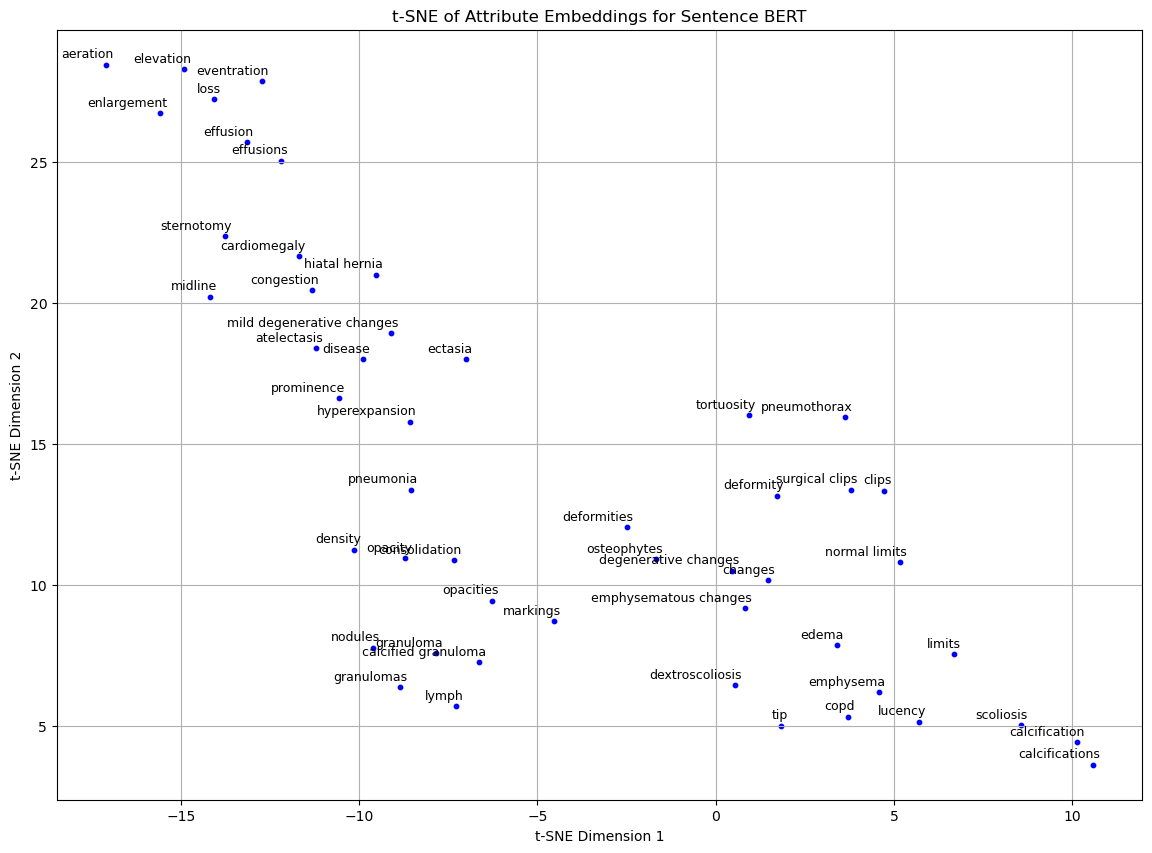

In [42]:
# Load the attribute embeddings
attr_to_emb = torch.load("C:/Users/DryLab/Desktop/ViLLA/data/open-i/attr_embs.pth")
attributes = list(attr_to_emb.keys())
attribute_embeddings = np.array([attr_to_emb[attr] for attr in attributes])
print(f"Attribute embeddings shape: {attribute_embeddings.shape}")

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=10)
embeddings_2d = tsne.fit_transform(attribute_embeddings)

# Create the plot
plt.figure(figsize=(14, 10))

# Plot the points
plt.scatter(
    embeddings_2d[:, 0], embeddings_2d[:, 1], color="blue", s=10
)  # s sets the point size

# Add labels with slight offsets
for i, attribute in enumerate(attributes):
    plt.annotate(
        attribute,
        (embeddings_2d[i, 0], embeddings_2d[i, 1]),
        textcoords="offset points",
        xytext=(5, 5),  # Adjust this to move labels
        ha="right",  # Horizontal alignment
        fontsize=9,  # Font size can be adjusted here
    )

plt.title("t-SNE of Attribute Embeddings for Sentence BERT")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(True)
plt.show()

In [30]:
df = pd.read_feather("C:/Users/DryLab/Desktop/ViLLA/data/open-i/annotations.feather")
df

,image_id,image_size,image_filepath,region_coord,region_bbox,region_labels,num_regions,text_filepath,text,sentences,attributes,split
0,0,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[16.0, 5.0, 97.0, 180.0], [107.0, 4.0, 187.0,...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,slight cardiomegaly . clear lungs .,"[slight cardiomegaly ., clear lungs .]",[cardiomegaly],train
1,1,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[20.0, 46.0, 105.0, 188.0], [111.0, 50.0, 189...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,heart size is within normal limits . low lung ...,"[heart size is within normal limits ., low lun...",[limits],train
2,2,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[30.0, 10.0, 105.0, 185.0], [115.0, 8.0, 197....","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"cardiac size , mediastinal contour , and pulmo...","[cardiac size , mediastinal contour , and pulm...",[normal limits],train
3,3,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[18.0, 15.0, 106.0, 162.0], [121.0, 10.0, 206...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,the heart size is normal . mediastinal contour...,"[the heart size is normal ., mediastinal conto...",[normal limits],train
4,4,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[25.0, 22.0, 105.0, 157.0], [110.0, 26.0, 194...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,the cardiomediastinal silhouette and vasculatu...,[the cardiomediastinal silhouette and vasculat...,[degenerative changes],train
...,...,...,...,...,...,...,...,...,...,...,...,...
2006,2006,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[23.0, 26.0, 114.0, 184.0], [126.0, 29.0, 204...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,the heart is normal in size and contour . stre...,"[the heart is normal in size and contour ., st...","[streaky opacities, atelectasis, opacities, at...",val
2007,2007,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[39.0, 20.0, 112.0, 156.0], [119.0, 21.0, 202...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,scattered degenerative changes of the thoracic...,[scattered degenerative changes of the thoraci...,[surgical clips],val
2008,2008,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[21.0, 13.0, 105.0, 188.0], [116.0, 11.0, 199...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,diffuse bilateral coarse interstitial markings...,[diffuse bilateral coarse interstitial marking...,"[normal limits, changes]",val
2009,2009,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[22.0, 4.0, 109.0, 149.0], [119.0, 6.0, 208.0...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,low lung volumes are present . the heart size ...,"[low lung volumes are present ., the heart siz...","[normal limits, mild degenerative]",val


In [832]:
def assign_sents_to_attributes(text, a):
    # Convert attribute to lowercase and split into individual words
    words = [word.lower() for word in a.split()]
    # print(words)
    selected_sents = []
    
    for i, sentence in enumerate(text):
        sentence_lower = sentence.lower()
        
        # Custom rule: if attribute is "within normal limits"
        if a.lower() == "within normal limits" and "limits" in sentence_lower:
            selected_sents.append(i)
        # Default rule: check if all words in the attribute are in the sentence
        elif all(word in sentence_lower for word in words):
            selected_sents.append(i)
    return np.random.choice(selected_sents)

In [840]:
# index = random.randint(0, len(df) - 1)
index = 0
# Identify sentences from the original description corresponding to each attribute
attribute_to_text = {}
text = [x.strip() for x in df.iloc[index]["text"].split(".") if len(x) > 3]
# print(text)
# text = df.iloc[index]["sentences"].tolist()
for a in df.iloc[index]["attributes"]:
    assigned_sents = assign_sents_to_attributes(text, a)
    attribute_to_text[a] = text[assigned_sents]

print(text)
attribute_to_text

[
    'the cardiac silhouette is at the upper limits of normal for size',
    'there are low lung volumes with bronchovascular crowding',
    'minimal degenerative endplate changes of the thoracic spine',
    'pulmonary hypoinflation'
]

{'within normal limits': 'the cardiac silhouette is at the upper limits of normal for size',
 'minimal degenerative changes': 'minimal degenerative endplate changes of the thoracic spine'}

### Check Mapping Results


In [25]:
# mapping_train = pd.read_feather(
#     "C:/Users/DryLab/Desktop/ViLLA/checkpoints/openi_stage1/runs/Sep02_10-55-53_DryLab/mapping_train.feather"
# )
mapping_train = pd.read_feather(
    r"C:\Users\DryLab\Desktop\ViLLA\checkpoints\openi_stage1\mapping_train.feather"
)

# mapping_train = pd.read_feather(r"C:\Users\DryLab\Desktop\ViLLA\checkpoints\openi_stage1\runs\openi_stage1_2024-11-04_10-16-32\mapping_train.feather")

In [26]:
mapping_train

,image_id,image_size,image_filepath,region_coord,region_bbox,region_labels,num_regions,text_filepath,text,sentences,attributes,split,assigned_attributes,assigned_text
0,0,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[33.0, 12.0, 107.0, 205.0], [115.0, 14.0, 183...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,heart size within normal limits .,[heart size within normal limits .],[limits],train,"[[limits], [], []]","[heart size within normal limits, , ]"
1,1,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[18.0, 27.0, 104.0, 166.0], [115.0, 24.0, 197...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"the heart , pulmonary [MASK] and mediastinum a...","[the heart , pulmonary [MASK] and mediastinum ...",[mild degenerative changes],train,"[[], [mild degenerative changes], []]","[, there are mild degenerative changes of the ..."
2,2,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[14.0, 21.0, 103.0, 171.0], [115.0, 22.0, 197...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,pa and moderate loss of the chest demonstrate ...,[pa and moderate loss of the chest demonstrate...,"[loss, ectasia, emphysematous changes, emphyse...",train,"[[], [loss, ectasia, emphysematous changes, em...","[, pa and moderate loss of the chest demonstra..."
3,3,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[27.0, 32.0, 121.0, 187.0], [130.0, 30.0, 215...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,moderate cardiomegaly . bibasilar and perihila...,"[moderate cardiomegaly ., bibasilar and perihi...","[cardiomegaly, opacities, cardiomegaly, edema]",train,"[[edema], [opacities], [cardiomegaly, cardiome...",[cardiomegaly and mild interstitial pulmonary ...
4,4,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[10.0, 25.0, 94.0, 164.0], [103.0, 20.0, 197....","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,heart size or great lungs are clear . calcifie...,"[heart size or great lungs are clear ., calcif...",[granuloma],train,"[[granuloma], [], []]",[calcified 5 mm granuloma in the right upper l...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1369,1369,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[21.0, 16.0, 113.0, 172.0], [122.0, 20.0, 191...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,the cardiac silhouette is near upper limits of...,[the cardiac silhouette is near upper limits o...,[granuloma],train,"[[granuloma], [], []]",[there is a small calcified granuloma in the l...
1370,1370,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[29.0, 31.0, 111.0, 151.0], [115.0, 31.0, 193...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,heart size mildly to moderately enlarged . mil...,"[heart size mildly to moderately enlarged ., m...","[elevation, cardiomegaly]",train,"[[], [], [elevation, cardiomegaly]]","[, , mild right hemidiaphragm elevation with m..."
1371,1371,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[12.0, 28.0, 98.0, 149.0], [115.0, 30.0, 198....","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,lungs are overall hyperexpanded with flattenin...,[lungs are overall hyperexpanded with flatteni...,[degenerative changes],train,"[[degenerative changes], [], []]","[degenerative changes in the thoracic spine, , ]"
1372,1372,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [27]:
from collections import defaultdict

import pandas as pd

# Initialize counters for empty findings
empty_counts = defaultdict(int)  # Using defaultdict to avoid key errors

# Loop through all rows in the dataframe
for index, row in mapping_train.iterrows():
    mappings = row["assigned_text"]

    # Iterate over each region
    for i in range(len(mappings)):
        region_attributes = mappings[i]
        if not region_attributes:  # Check if the region's attribute list is empty
            empty_counts[i + 1] += (
                1  # Increment empty count for the corresponding region
            )

# Print total empty labels for each region
print("Total empty labels for each region:")
for region, count in empty_counts.items():
    print(f"REGION {region}: {count} empty findings")

Total empty labels for each region:

REGION 2: 635 empty findings

REGION 3: 866 empty findings

REGION 1: 545 empty findings

In [32]:
def plot_bounding_boxes_for_index(
    df, index, image_column="image_filepath", bbox_column="region_bbox"
):
    processor = MedCLIPProcessor()
    # Load the image using the index
    image_path = df[image_column].iloc[index]
    # image = Image.open(image_path).convert("L")
    # image = processor(images=image, return_tensors="pt")
    # image = image["pixel_values"][0]
    image = process_image(image_path)

    # Extract the bounding boxes
    bounding_boxes = df[bbox_column].iloc[index]

    # Plot the image with bounding boxes
    fig, ax = plt.subplots(1)
    ax.imshow(image.squeeze(), cmap="gray")

    # Unpack the bounding boxes
    left_lung_bbox = bounding_boxes[0]
    right_lung_bbox = bounding_boxes[1]
    heart_bbox = bounding_boxes[2]

    # Define bounding boxes' colors
    colors = ["r", "g", "b"]  # Red for right lung, Green for left lung, Blue for heart

    # Create rectangles for each bounding box and add them to the plot
    for bbox, color in zip([left_lung_bbox, right_lung_bbox, heart_bbox], colors):
        if not np.array_equal(
            bbox, [0, 0, 0, 0]
        ):  # Skip if the bbox is just a placeholder
            rect = patches.Rectangle(
                (bbox[0], bbox[1]),
                bbox[2] - bbox[0],
                bbox[3] - bbox[1],
                linewidth=2,
                edgecolor=color,
                facecolor="none",
            )
            ax.add_patch(rect)

    # Hide axis and show the plot
    plt.title(f"Bounding Boxes for Image {index}")
    plt.axis(False)
    plt.show()

In [33]:
mapping_train.iloc[index]['text']

'heart size within normal limits . osseous structures appear intact .'

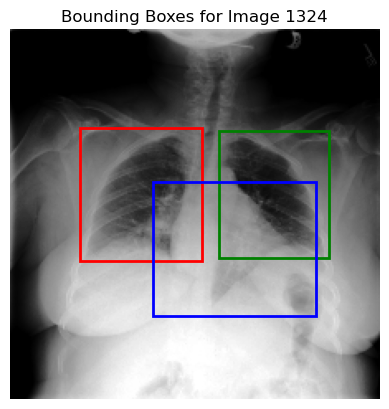

Original Text Report: there extremely low lung volumes . there is right basilar opacity . cardiac silhouette and 
mediastinal contours are within normal limits . low lung volumes with right basilar atelectasis .

Original Attributes: ['opacity' 'limits' 'atelectasis']

REGION-ATTRIBUTE PAIRS 1324:

REGION 1: cardiac silhouette and mediastinal contours are within normal limits

REGION 1 ATTRIBUTES: ['limits']

REGION 2: there is right basilar opacity . low lung volumes with right basilar atelectasis

REGION 2 ATTRIBUTES: ['opacity' 'atelectasis']

REGION 3 is empty!

In [41]:
import matplotlib.pyplot as plt

index = random.randint(0, len(mapping_train) - 1)
# index = 231

plot_bounding_boxes_for_index(mapping_train, index)

print(f"Original Text Report: {mapping_train['text'].iloc[index]}")
print(f"Original Attributes: {mapping_train['attributes'].iloc[index]}")
print(f"REGION-ATTRIBUTE PAIRS {index}:")

mappings = mapping_train["assigned_text"].values[index]
for i in range(len(mappings)):
    if not mappings[i]:
        print(f"\tREGION {i+1} is empty!")
    else:
        print(f"\tREGION {i+1}:", mappings[i])
        print(
            f"\tREGION {i+1} ATTRIBUTES:",
            mapping_train["assigned_attributes"].values[index][i],
        )

### Mapping Results DOCMNIST (30 Epochs, Lowest Loss: 0.28)


In [152]:
mapping_train = pd.read_feather(
    "C:/Users/DryLab/Desktop/ViLLA/checkpoints/docmnist_stage1/mapping_val.feather"
)

In [153]:
mapping_train.iloc[24]

image_id                                                           10203
image_size                                                      [84, 84]
image_filepath         C:\Users\DryLab\Desktop\ViLLA\data\docmnist_30...
region_coord           [[0, 0, 28, 28], [28, 0, 56, 28], [56, 0, 84, ...
num_regions                                                            9
split                                                                val
text                   the shape size is small . the image is blue . ...
digit_label            [four, seven, one, four, eight, three, zero, n...
color_label            [blue, purple, blue, purple, purple, purple, g...
shape_label            [circle, rectangle, rectangle, None, rectangle...
size_label             [large, large, large, None, small, small, larg...
reg_to_attr            [[four, blue, circle, large], [seven, purple, ...
attributes             [purple, seven, yellow, circle, one, small, bl...
assigned_attributes    [[circle, blue, large, eight

In [154]:
mapping_train.iloc[24].attributes

array(['purple', 'seven', 'yellow', 'circle', 'one', 'small', 'blue',
       'green', 'large', 'three', 'eight', 'nine', 'four', 'rectangle',
       'zero'], dtype=object)

In [155]:
mapping_train.iloc[24].assigned_attributes

array([array(['circle', 'blue', 'large', 'eight', 'four'], dtype=object),
       array(['purple', 'one', 'small', 'rectangle'], dtype=object),
       array(['seven', 'one', 'blue', 'large', 'rectangle'], dtype=object),
       array(['purple', 'four'], dtype=object),
       array(['purple', 'circle', 'one', 'small', 'eight', 'four'], dtype=object),
       array(['purple', 'three'], dtype=object),
       array(['circle', 'green', 'zero'], dtype=object),
       array(['yellow', 'eight', 'nine', 'rectangle'], dtype=object),
       array(['blue', 'four'], dtype=object)], dtype=object)

Original Text Report: the color is blue . the size of the shape is small . the digit appears to be two . the digit 
appears to be purple . the shape appears to be a circle . the digit appears to be blue . the digit appears to be 
red . the shape is a circle . the shape is large . the size of the shape is large . there is an image showing a 
five . the image shows a five . there is a purple image . the image shows a six . the image is yellow . the digit 
appears to be one . the image has a rectangle . the image is green . the image shows a four . the shape size is 
large . the digit appears to be nine . the shape is a rectangle . the image has a circle . the shape is small . the
shape appears to be a rectangle . the digit appears to be yellow . the image shows a one

Original Attributes: ['red' 'six' 'yellow' 'small' 'one' 'circle' 'green' 'blue' 'five' 'large'
 'nine' 'purple' 'rectangle' 'two' 'four']

REGION-ATTRIBUTE PAIRS:

REGION 1: the image shows a one . the digit appears to be blue

REGION 1 ATTRIBUTES: ['one' 'blue']

REGION 1 Ground Truth: ['one' 'blue']

REGION 2: the image is green . the digit appears to be nine . the image has a rectangle

REGION 2 ATTRIBUTES: ['green' 'nine' 'rectangle']

REGION 2 Ground Truth: ['nine' 'green' 'rectangle' 'small']

REGION 3: the image is yellow . the shape is a circle . the image shows a five . the size of the shape is 
large

REGION 3 ATTRIBUTES: ['yellow' 'circle' 'five' 'large']

REGION 3 Ground Truth: ['five' 'yellow' 'circle' 'large']

REGION 4: the shape is a circle . the digit appears to be nine . there is a purple image

REGION 4 ATTRIBUTES: ['circle' 'nine' 'purple']

REGION 4 Ground Truth: ['nine' 'purple']

REGION 5: the image shows a six . the shape is a circle . there is a purple image

REGION 5 ATTRIBUTES: ['six' 'circle' 'purple']

REGION 5 Ground Truth: ['six' 'purple' 'circle' 'small']

REGION 6: the digit appears to be blue . the image has a rectangle . the digit appears to be two

REGION 6 ATTRIBUTES: ['blue' 'rectangle' 'two']

REGION 6 Ground Truth: ['two' 'blue' 'rectangle' 'large']

REGION 7: the size of the shape is large . the digit appears to be nine . there is a purple image . the 
image has a rectangle

REGION 7 ATTRIBUTES: ['large' 'nine' 'purple' 'rectangle']

REGION 7 Ground Truth: ['five' 'purple' 'rectangle' 'large']

REGION 8: the digit appears to be red . the size of the shape is small . the image has a rectangle . the 
image shows a four

REGION 8 ATTRIBUTES: ['red' 'small' 'rectangle' 'four']

REGION 8 Ground Truth: ['four' 'red' 'rectangle' 'small']

REGION 9: the image is yellow . the shape is a circle . the size of the shape is large

REGION 9 ATTRIBUTES: ['yellow' 'circle' 'large']

REGION 9 Ground Truth: ['one' 'yellow' 'circle' 'large']

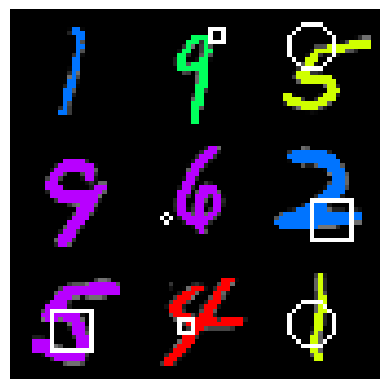

In [158]:
import random

index = random.randint(0, len(mapping_train) - 1)

img = sparse.load_npz(mapping_train["image_filepath"].iloc[index]).todense() / 255
plt.imshow(img.transpose(1, 2, 0))
plt.axis(False)
print(f"Original Text Report: {mapping_train['text'].iloc[index]}")
print(f"Original Attributes: {mapping_train['attributes'].iloc[index]}")
print("REGION-ATTRIBUTE PAIRS:")
mappings = mapping_train["assigned_text"].values[index]
for i in range(len(mappings)):
    print(f"\tREGION {i+1}:", mappings[i])
    print(
        f"\tREGION {i+1} ATTRIBUTES:",
        mapping_train["assigned_attributes"].values[index][i],
    )
    print(f"\tREGION {i+1} Ground Truth:", mapping_train["reg_to_attr"].iloc[index][i])

In [129]:
df = pd.read_feather("C:/Users/DryLab/Desktop/ViLLA/data/open-i/annotations.feather")

In [105]:
def assign_sents_to_attributes(text, a):
    text = [t.lower() for t in text]
    selected_sents = []
    for i in range(len(text)):
        if f"{a}" in text[i]:
            selected_sents.append(i)
    return np.random.choice(selected_sents)

In [119]:
for idx, row in df.iterrows():
    attribute_to_text = {}
    text = [x.strip() for x in row["text"].split(".") if len(x) > 3]
    for a in row["attributes"]:
        assigned_sents = assign_sents_to_attributes(text, a)
        attribute_to_text[a] = text[assigned_sents]

In [120]:
attribute_to_text

{'density': 'increased size of density in the left cardiophrenic xxxx',
 'size': 'increased size of density in the left cardiophrenic xxxx'}

In [121]:
attribute_to_text

{'density': 'increased size of density in the left cardiophrenic xxxx',
 'size': 'increased size of density in the left cardiophrenic xxxx'}

In [130]:
df

,image_id,image_size,image_filepath,region_coord,region_bbox,region_labels,num_regions,text_filepath,text,sentences,attributes,split
0,0,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[7, 16, 111, 175], [142, 14, 223, 159], [87, ...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,the cardiac silhouette is within normal limits...,[the cardiac silhouette is within normal limit...,"[atelectasis, limits, opacity]",train
1,1,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[2, 13, 92, 172], [123, 12, 208, 176], [72, 9...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,the cardiac silhouette is within normal limits...,[the cardiac silhouette is within normal limit...,"[atelectasis, limits, opacity]",train
4,4,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[17, 26, 92, 174], [117, 21, 213, 180], [78, ...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,there appears to be air within this which coul...,[there appears to be air within this which cou...,"[atelectasis, calcification, density, opacity]",train
5,5,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[16, 25, 102, 178], [126, 25, 203, 183], [85,...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,there is no pleural effusion or pneumothorax ....,[there is no pleural effusion or pneumothorax ...,[changes],train
8,8,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[24, 11, 103, 201], [130, 11, 197, 198], [91,...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"the lungs are clear , without evidence of acut...","[the lungs are clear , without evidence of acu...",[changes],train
...,...,...,...,...,...,...,...,...,...,...,...,...
3792,3792,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[26, 11, 107, 172], [132, 18, 203, 194], [84,...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"no focal consolidation , pneumothorax , or ple...","[no focal consolidation , pneumothorax , or pl...",[disease],val
3793,3793,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[25, 10, 98, 199], [125, 8, 193, 210], [88, 1...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,cardiomediastinal silhouette is within normal ...,[cardiomediastinal silhouette is within normal...,[limits],val
3794,3794,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[24, 1, 93, 158], [124, 2, 196, 185], [85, 76...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,cardiomediastinal silhouette is within normal ...,[cardiomediastinal silhouette is within normal...,[limits],val
3795,3795,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[31, 9, 99, 160], [123, 13, 199, 188], [88, 9...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,clear lungs .trachea is midline .no pneumothor...,"[clear lungs .trachea is midline .no, pneumoth...",[midline],val


# Create Ground Truth

In [876]:
df = pd.read_feather("C:/Users/DryLab/Desktop/ViLLA/data/open-i/annotations.feather")
df

,image_id,image_size,image_filepath,region_coord,region_bbox,region_labels,num_regions,text_filepath,text,sentences,attributes,split,reg_to_attr
0,0,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[32.0, 18.0, 110.0, 148.0], [115.0, 18.0, 197...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,the cardiac silhouette is at the upper limits ...,[the cardiac silhouette is at the upper limits...,"[within normal limits, minimal degenerative ch...",train,"[, , ]"
1,1,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[32.0, 1.0, 106.0, 155.0], [116.0, 0.0, 197.0...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,heart size is normal status post [MASK] sterno...,[heart size is normal status post [MASK] stern...,[degenerative changes],train,"[, , ]"
2,2,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[33.0, 22.0, 104.0, 151.0], [111.0, 21.0, 180...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,the heart is normal in size . the pulmonary va...,"[the heart is normal in size ., the pulmonary ...",[within normal limits],train,"[, , ]"
3,3,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[22.0, 28.0, 105.0, 184.0], [118.0, 22.0, 204...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,there is hyperinflation of the lungs but they ...,[there is hyperinflation of the lungs but they...,"[hyperinflation, copd]",train,"[, , ]"
4,4,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[37.0, 29.0, 116.0, 157.0], [121.0, 26.0, 203...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,the heart is normal in size . the mediastinum ...,"[the heart is normal in size ., the mediastinu...",[small effusions],train,"[, , ]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1957,1957,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[46.0, 24.0, 117.0, 169.0], [124.0, 27.0, 189...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,pa and lateral views the chest were obtained ....,[pa and lateral views the chest were obtained ...,[within normal limits],val,"[, , ]"
1958,1958,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[12.0, 33.0, 98.0, 202.0], [110.0, 35.0, 197....","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,the cardiomediastinal silhouette and vasculatu...,[the cardiomediastinal silhouette and vasculat...,[degenerative changes],val,"[, , ]"
1959,1959,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[30.0, 68.0, 103.0, 194.0], [110.0, 62.0, 173...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,ap and lateral view of the chest . cardiomegal...,"[ap and lateral view of the chest ., cardiomeg...","[congestion, small effusions, cardiomegaly]",val,"[, , cardiomegaly]"
1960,1960,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[39.0, 23.0, 114.0, 161.0], [122.0, 23.0, 191...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"heart size , mediastinal contour , and pulmona...","[heart size , mediastinal contour , and pulmon...",[within normal limits],val,"[, , ]"


In [878]:
df['reg_to_attr'] = df['attributes'].apply(lambda x: np.array([[''], [''], ['']], dtype=object))
df

,image_id,image_size,image_filepath,region_coord,region_bbox,region_labels,num_regions,text_filepath,text,sentences,attributes,split,reg_to_attr
0,0,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[32.0, 18.0, 110.0, 148.0], [115.0, 18.0, 197...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,the cardiac silhouette is at the upper limits ...,[the cardiac silhouette is at the upper limits...,"[within normal limits, minimal degenerative ch...",train,"[[], [], []]"
1,1,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[32.0, 1.0, 106.0, 155.0], [116.0, 0.0, 197.0...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,heart size is normal status post [MASK] sterno...,[heart size is normal status post [MASK] stern...,[degenerative changes],train,"[[], [], []]"
2,2,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[33.0, 22.0, 104.0, 151.0], [111.0, 21.0, 180...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,the heart is normal in size . the pulmonary va...,"[the heart is normal in size ., the pulmonary ...",[within normal limits],train,"[[], [], []]"
3,3,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[22.0, 28.0, 105.0, 184.0], [118.0, 22.0, 204...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,there is hyperinflation of the lungs but they ...,[there is hyperinflation of the lungs but they...,"[hyperinflation, copd]",train,"[[], [], []]"
4,4,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[37.0, 29.0, 116.0, 157.0], [121.0, 26.0, 203...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,the heart is normal in size . the mediastinum ...,"[the heart is normal in size ., the mediastinu...",[small effusions],train,"[[], [], []]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1957,1957,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[46.0, 24.0, 117.0, 169.0], [124.0, 27.0, 189...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,pa and lateral views the chest were obtained ....,[pa and lateral views the chest were obtained ...,[within normal limits],val,"[[], [], []]"
1958,1958,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[12.0, 33.0, 98.0, 202.0], [110.0, 35.0, 197....","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,the cardiomediastinal silhouette and vasculatu...,[the cardiomediastinal silhouette and vasculat...,[degenerative changes],val,"[[], [], []]"
1959,1959,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[30.0, 68.0, 103.0, 194.0], [110.0, 62.0, 173...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,ap and lateral view of the chest . cardiomegal...,"[ap and lateral view of the chest ., cardiomeg...","[congestion, small effusions, cardiomegaly]",val,"[[], [], []]"
1960,1960,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[39.0, 23.0, 114.0, 161.0], [122.0, 23.0, 191...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"heart size , mediastinal contour , and pulmona...","[heart size , mediastinal contour , and pulmon...",[within normal limits],val,"[[], [], []]"


In [ ]:
modified_indices = []  # To store indices that have been modified
for index, row in df.iterrows():
    # Check if any attribute contains 'cardiomegaly' or 'pacemaker' (substring match)
    if any('cardiomegaly' in attr or 'tortuosity' in attr for attr in row['attributes']):
        reg_to_attr = row['reg_to_attr'].copy()  # Create a copy of the array
        # Assign the matched attribute to the third region
        matched_attrs = [attr for attr in row['attributes'] if 'cardiomegaly' in attr or 'tortuosity' in attr]
        reg_to_attr[2][0] = ', '.join(matched_attrs)  # Join matched attributes if multiple
        df.at[index, 'reg_to_attr'] = reg_to_attr  # Reassign the modified array
        modified_indices.append(index)  # Track modified index
        print(f"Modified index: {index}")  # Print the modified index

# print("Modified indices:", modified_indices)

In [880]:
df

,image_id,image_size,image_filepath,region_coord,region_bbox,region_labels,num_regions,text_filepath,text,sentences,attributes,split,reg_to_attr
0,0,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[32.0, 18.0, 110.0, 148.0], [115.0, 18.0, 197...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,the cardiac silhouette is at the upper limits ...,[the cardiac silhouette is at the upper limits...,"[within normal limits, minimal degenerative ch...",train,"[[], [], []]"
1,1,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[32.0, 1.0, 106.0, 155.0], [116.0, 0.0, 197.0...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,heart size is normal status post [MASK] sterno...,[heart size is normal status post [MASK] stern...,[degenerative changes],train,"[[], [], []]"
2,2,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[33.0, 22.0, 104.0, 151.0], [111.0, 21.0, 180...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,the heart is normal in size . the pulmonary va...,"[the heart is normal in size ., the pulmonary ...",[within normal limits],train,"[[], [], []]"
3,3,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[22.0, 28.0, 105.0, 184.0], [118.0, 22.0, 204...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,there is hyperinflation of the lungs but they ...,[there is hyperinflation of the lungs but they...,"[hyperinflation, copd]",train,"[[], [], []]"
4,4,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[37.0, 29.0, 116.0, 157.0], [121.0, 26.0, 203...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,the heart is normal in size . the mediastinum ...,"[the heart is normal in size ., the mediastinu...",[small effusions],train,"[[], [], []]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1957,1957,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[46.0, 24.0, 117.0, 169.0], [124.0, 27.0, 189...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,pa and lateral views the chest were obtained ....,[pa and lateral views the chest were obtained ...,[within normal limits],val,"[[], [], []]"
1958,1958,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[12.0, 33.0, 98.0, 202.0], [110.0, 35.0, 197....","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,the cardiomediastinal silhouette and vasculatu...,[the cardiomediastinal silhouette and vasculat...,[degenerative changes],val,"[[], [], []]"
1959,1959,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[30.0, 68.0, 103.0, 194.0], [110.0, 62.0, 173...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,ap and lateral view of the chest . cardiomegal...,"[ap and lateral view of the chest ., cardiomeg...","[congestion, small effusions, cardiomegaly]",val,"[[], [], [cardiomegaly]]"
1960,1960,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[39.0, 23.0, 114.0, 161.0], [122.0, 23.0, 191...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"heart size , mediastinal contour , and pulmona...","[heart size , mediastinal contour , and pulmon...",[within normal limits],val,"[[], [], []]"


In [881]:
# Flatten the reg_to_attr column
df['reg_to_attr'] = df['reg_to_attr'].apply(lambda x: x.flatten())
df['reg_to_attr'].iloc[9].shape

(3,)

In [882]:
df['reg_to_attr'].iloc[309]

array(['', '', 'mild tortuosity'], dtype=object)

In [883]:
df['attributes'].iloc[309]

array(['within normal limits', 'degenerative changes', 'mild tortuosity'],
      dtype=object)

In [884]:
df['text'].iloc[309]

'heart size and pulmonary vascularity appear within normal limits . there is mild tortuosity to the descending thoracic aorta . degenerative changes are present in the spine .'

In [885]:
df.to_feather("C:/Users/DryLab/Desktop/ViLLA/data/open-i/annotations.feather")